# Handling text exercise

## Welcome! This exercise consists of:

## Part 1: Hands on tutorial
1. Implementing the natural language processing pipeline
2. Solving four typical language processing tasks:
   * Sentiment analysis
   * Document classification
   * Topic detection
   * Semantic analysis


### We will be working with four books in plain text:
1. Moby-Dick, by Herman Melville
2. Frankenstein; or, The Modern Prometheus, by Mary Shelley
3. Pride and Prejudice, by Jane Austen
4. Dracula, Bram Stoker

#### To run this notebook, you need to install the following libraries:

conda install nltk gensim spacy <br>
pip install pyLDAvis  <br>
pip install vaderSentiment  <br>
pip install empath <br>
python -m spacy download en  <br>
python -m nltk.downloader punkt <br>
python -m nltk.downloader all-corpora <br>

## Part 2: Handling text comprehension questions
- You can test your understanding of important NLP concepts. Solutions will be released next week.

## Part 3: Coding exercise
- When you are done, in "Handling_text_exercise_2.ipynb", you will find additional exercises you can work on independently.

## Part 1

In [65]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#The data
corpus_root = 'books/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### In this tutorial we will be working with text in English. The same principles apply, but the methods cannot be applied directly to the text in unknown or other languages. We will be working mainly with the Spacy library.

Initialize the Spacy analyzer in English

加载一个预训练的 spaCy NLP 语言模型，这里的 en_core_web_sm 是一个小型的英文模型。加载后，语言模型对象会被存储到变量 nlp 中，作为一个 NLP 管道（pipeline）

In [66]:
nlp = spacy.load('en_core_web_sm')

Load the books

In [67]:
books = list() # 创建一个空列表 books，用来存储每个 .txt 文件的内容

# 使用 os.listdir() 列出指定文件夹 corpus_root 中的所有文件和文件夹
# os.listdir() 不会区分文件和文件夹，因此需要进一步判断是否是 .txt 文件。
# 使用 os.path.join(corpus_root, book_file) 将目录路径和文件名拼接成文件的完整路径
# 使用 codecs.open() 以 UTF-8 编码打开文件。这样可以避免因为文件编码问题导致的报错。
# with 语句：确保文件使用后被正确关闭，避免文件资源占用。
# 使用 f.read() 读取整个文件的内容，并将其存储到变量中。
# 使用 books.append() 将文件内容作为字符串添加到 books 列表中。
for book_file in os.listdir(corpus_root): 
    if ".txt" in book_file:
        print(book_file)
        with codecs.open(os.path.join(corpus_root,book_file),encoding="utf8") as f:
            books.append(f.read())

DRACULA.txt
Frankenstein.txt
Moby_Dick.txt
PRIDE_AND_PREJUDICE.txt


Print the beginning of Pride and Prejudice

In [68]:
print(books[3][0:600]) 
# 打印books列表中第四个文本的前600个字符
# 0:600 表示从字符串的第 0 个字符开始，提取前 600 个字符（不包括第 600 个字符）

PRIDE AND PREJUDICE

By Jane Austen



Chapter 1


It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he is considered the rightful property
of some one or other of their daughters.

“My dear Mr. Bennet,” said his lady to him one day, “have you heard that
Netherfield Park is let at last?”

Mr. Bennet replied that he had not.

“But


#### Let's remove the new lines

In [69]:
# 对 books 列表中的每个文本字符串进行预处理，移除多余的空白字符（包括换行符和多余空格），使每个文本成为一个清洁的字符串
# for b in books: 遍历 books 列表，b 是每次迭代时获取的一个字符串（对应某个文件的内容）
# " ".join(b.split()): 对每个字符串 b 进行处理，移除多余空白，并将结果重新拼接成一个干净的字符串
books = [" ".join(b.split()) for b in books]

In [70]:
print(books[3][0:600])

PRIDE AND PREJUDICE By Jane Austen Chapter 1 It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters. “My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs.


### Load Frankenstein

In [71]:
#index all books
book = books[1]

#put in raw text, get a Spacy object
doc = nlp(book)

## Let's create our own NLP pipeline with Spacy!

### Step 1: Sentence splitting

#### May sound trivial, but it's not! (e.g., U.K. or Yahoo!) Spacy uses a statistical model to generate accurate predictions. This works well out of the box for general-purpose text or web text. For social media use dedicated libraries.

**1. 什么是句子分割？**

- **句子分割** 是将一段连续的文本分割成单独的句子。比如：

  ```text
  Hello world! This is an example. I am learning NLP.
  ```

  被分割为三句话：

  1. `Hello world!`

  2. `This is an example.`

  3. `I am learning NLP.`

- 表面上看，句子分割似乎很简单，但实际上可能会遇到一些棘手的问题，例如：

  - **缩写**：

    - `U.K.` 是一个国家名称，而不是句子结束。

    - `e.g.` 是缩写形式，也不应该被错误地识别为句子结束。

  - **标点歧义**：

    - `Yahoo!` 是公司名称，而不是句子结束。

  - **多种语言支持**：

    - 不同语言的分割规则可能差异很大，比如中文没有句号分隔。

**2. SpaCy 如何处理句子分割？**

- SpaCy 使用的是 **统计模型** 来预测句子边界，而不是简单地基于规则（如检测标点符号）。

  - **统计模型**：模型会根据上下文信息（如单词之间的关系）来判断某个标点是否是句子的结束标志。

  - 优点：能处理常见的标点歧义问题，适用于通用文本和网络文本。

**3. 为什么社交媒体需要专门的库？**

- **社交媒体文本** 通常非常不同于标准的通用文本，可能包含：

  1. **缩写和俚语**：如 `brb`（be right back）、`LOL`（laugh out loud）。

  2. **缺少标点**：很多社交媒体帖子没有使用正确的标点。

  3. **非正式表达**：如重复字母、表情符号等。

  4. **混合语言**：如英文和其他语言的代码混合。

- SpaCy 的模型是针对通用文本训练的，可能不适用于这些非正式的语言现象。因此，社交媒体文本的句子分割更适合使用专门的工具，如：

  - **TweetNLP**：专门针对推文的 NLP 库。
  
  - **NLTK**：有针对更复杂句子分割的功能模块。

In [72]:
# doc.sents 是一个生成器，用来逐一生成文本中的句子。
# sents 是 spaCy 自动检测的句子边界，基于内置的句子分割模型。
# sent 是每次迭代时生成的句子对象，sent.text 是句子的字符串形式。
sentences = [sent for sent in doc.sents]
print('Sentence 1:',sentences[0],'\n')
print('Sentence 2:',sentences[1],'\n')
print('Sentence 3:',sentences[2],'\n')

Sentence 1: Frankenstein, or the Modern Prometheus by Mary Wollstonecraft (Godwin) Shelley Letter 1 St. Petersburgh, Dec. 11th, 17-- TO Mrs. Saville, England You will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings. 

Sentence 2: I arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking. 

Sentence 3: I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 



### Step 2: Tokenization

#### The task of splitting a text into meaningful segments called tokens. We segment the sentence into words, punctuation, etc. This is done by first splitting on whitespace characters and them applying rules specific to each language. For example, "don't" does not contain whitespace, but should be split into two tokens, "do" and "n't", while "U.K." should always remain one token and "but," shouldn't.

分词的任务是将文本分割成有意义的片段，这些片段被称为**token（标记）**。我们将句子分割成单词、标点符号等。这一过程首先通过空白字符进行初步分割，然后再根据每种语言的规则进行进一步处理。例如：

- "don't" 没有空白字符，但应该分割成两个标记 "do" 和 "n't"。

- 而 "U.K." 应始终作为一个标记保留。

- 同时像 "but," 这样的词，标点符号应被单独分离。

**1. 什么是分词（Tokenization）？**

- **分词** 是自然语言处理（NLP）中的一个基础步骤，其任务是将一段文本分解为更小的单元，称为 **token**。

  - **token**：可以是一个单词、数字、标点符号，甚至是一个短语，具体取决于上下文和应用需求。

  - 分词是文本数据处理的第一步，很多 NLP 应用都依赖于分词后的数据。

**2. 为什么分词不是简单的按空格切割？**

虽然看起来分词可以简单地通过空格 `split()` 完成，但在实际的自然语言处理中存在一些复杂性：

1. **复合单词与缩写**：

   - **示例**：

     - "don't" 不是一个独立的单词，它实际上是 "do" 和 "n't" 的组合。

     - "U.K." 是一个国家名称，不应被错误地分割为 "U" 和 "K"。

2. **标点符号的处理**：

   - 标点符号需要单独分离，但不能与单词混淆。

   - **示例**：

     - 在 "but," 中，标点 "," 应该单独作为一个 token。

     - 但不能错误地将 "U.K." 的句点 "." 分割出来。

3. **多语言的复杂性**：

   - 不同语言的规则不同。例如，中文没有空格，需要根据词库进行分词，而英文则可以以空格为基础。

**3. SpaCy 如何进行分词？**

- SpaCy 使用预定义的语言模型，通过 **空格分割** 和 **语言规则** 结合的方式实现分词。

- SpaCy 的分词器会：

  1. **初步分割**：以空白字符（空格、换行符等）为基础，分割文本。

  2. **语言规则调整**：根据语言模型中的规则，进一步对特殊情况进行处理。例如：

     - "don't" 会被分割为两个 token："do" 和 "n't"。

     - "U.K." 会被保留为一个 token。

**4. 示例代码**

假设我们有一段文本：
```python
text = "I live in the U.K. and I don't know what to do, but I'll try."
```

**输出**：
```plaintext
Token: I
Token: live
Token: in
Token: the
Token: U.K.
Token: and
Token: I
Token: do
Token: n't
Token: know
Token: what
Token: to
Token: do
Token: ,
Token: but
Token: I
Token: 'll
Token: try
Token: .
```

### We will analyze the methods on an example sentence first

In [73]:
example = 'I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight.'

doc = nlp(example)

#strings are encoded to hashes
tokens = [token.text for token in doc]

print(example,'\n')
print(tokens)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

['I', 'am', 'already', 'far', 'north', 'of', 'London', ',', 'and', 'as', 'I', 'walk', 'in', 'the', 'streets', 'of', 'Petersburgh', ',', 'I', 'feel', 'a', 'cold', 'northern', 'breeze', 'play', 'upon', 'my', 'cheeks', ',', 'which', 'braces', 'my', 'nerves', 'and', 'fills', 'me', 'with', 'delight', '.']


### Step 3: Part of speech tagging

#### The model makes a prediction of which tag or label most likely applies in this context. For example, a word following "the" in English is most likely a noun.

这段代码的作用是对文本 **`doc`** 进行 **词性标注（POS tagging）**，并将每个词汇及其对应的词性存储为一个元组列表，最后打印结果。

**1. 创建 `pos_tagged` 列表**
```python
pos_tagged = [(token.text, token.pos_) for token in doc]
```

- **`doc`**:

  - `doc` 是 spaCy 处理后的 `Doc` 对象，表示已经通过 NLP 模型分析的文本。

  - 它包含了文本的所有分词结果、词性标注、依存关系、实体识别等信息。

  - **`token.text`**：

    - 表示分词后的具体单词或标点符号（如 `"The"`, `"dog"`, `","`, `"ran"`）。

  - **`token.pos_`**：

    - 表示该词的词性（如 `"NOUN"`, `"VERB"`, `"ADJ"` 等）。

  - 生成的元组 **`(token.text, token.pos_)`** 表示每个词及其对应的词性。

  - 将所有元组存储为一个列表，赋值给变量 `pos_tagged`。

**输出结构**：

假设 `doc` 是以下文本：
```python
doc = nlp("The dog ran quickly.")
```

生成的 `pos_tagged` 结果是：
```python
pos_tagged = [
    ('The', 'DET'),    # "The" 是一个限定词（Determiner）
    ('dog', 'NOUN'),   # "dog" 是一个名词
    ('ran', 'VERB'),   # "ran" 是一个动词
    ('quickly', 'ADV'),# "quickly" 是一个副词
    ('.', 'PUNCT')     # "." 是一个标点符号
]
```

In [74]:
pos_tagged = [(token.text, token.pos_) for token in doc]

print(example,'\n')
print(pos_tagged)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

[('I', 'PRON'), ('am', 'AUX'), ('already', 'ADV'), ('far', 'ADV'), ('north', 'ADV'), ('of', 'ADP'), ('London', 'PROPN'), (',', 'PUNCT'), ('and', 'CCONJ'), ('as', 'SCONJ'), ('I', 'PRON'), ('walk', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('streets', 'NOUN'), ('of', 'ADP'), ('Petersburgh', 'PROPN'), (',', 'PUNCT'), ('I', 'PRON'), ('feel', 'VERB'), ('a', 'DET'), ('cold', 'ADJ'), ('northern', 'ADJ'), ('breeze', 'NOUN'), ('play', 'VERB'), ('upon', 'SCONJ'), ('my', 'PRON'), ('cheeks', 'NOUN'), (',', 'PUNCT'), ('which', 'PRON'), ('braces', 'VERB'), ('my', 'PRON'), ('nerves', 'NOUN'), ('and', 'CCONJ'), ('fills', 'VERB'), ('me', 'PRON'), ('with', 'ADP'), ('delight', 'NOUN'), ('.', 'PUNCT')]


In [75]:
print(spacy.explain('CCONJ'))   # 并列连词
print(spacy.explain('ADP'))     # 介词或后置词
print(spacy.explain('DET'))     # 限定词

coordinating conjunction
adposition
determiner


### When unsure, see here for more details: http://universaldependencies.org/u/pos/all.html

#### More detailed annotation:

这段代码的作用是通过 **spaCy** 对文本 **`doc`** 进行详细的词性标注（POS tagging），并将每个单词及其对应的 **详细词性（`tag_`）** 存储为一个元组列表。最后打印出该列表。

```python
pos_tagged = [(token.text, token.tag_) for token in doc]
```

- **`token.tag_`**:

  - 表示分词的 **详细词性标签**（fine-grained POS tag）。

  - 与 `token.pos_` 的 **粗略词性标签（如名词、动词、形容词等）** 不同，`token.tag_` 提供了更细粒度的词性信息，包括语法属性（如时态、数、性等）。

  - 例如：

    - `VBD` 表示动词的过去式（如 "ran"）。

    - `NN` 表示单数的普通名词（如 "dog"）。

    - `NNS` 表示复数的普通名词（如 "dogs"）。

In [76]:
pos_tagged = [(token.text, token.tag_) for token in doc]

print(pos_tagged)

[('I', 'PRP'), ('am', 'VBP'), ('already', 'RB'), ('far', 'RB'), ('north', 'RB'), ('of', 'IN'), ('London', 'NNP'), (',', ','), ('and', 'CC'), ('as', 'IN'), ('I', 'PRP'), ('walk', 'VBP'), ('in', 'IN'), ('the', 'DT'), ('streets', 'NNS'), ('of', 'IN'), ('Petersburgh', 'NNP'), (',', ','), ('I', 'PRP'), ('feel', 'VBP'), ('a', 'DT'), ('cold', 'JJ'), ('northern', 'JJ'), ('breeze', 'NN'), ('play', 'VB'), ('upon', 'IN'), ('my', 'PRP$'), ('cheeks', 'NNS'), (',', ','), ('which', 'WDT'), ('braces', 'VBZ'), ('my', 'PRP$'), ('nerves', 'NNS'), ('and', 'CC'), ('fills', 'VBZ'), ('me', 'PRP'), ('with', 'IN'), ('delight', 'NN'), ('.', '.')]


In [77]:
print(spacy.explain('PRP'))
print(spacy.explain('VBP'))

pronoun, personal
verb, non-3rd person singular present


### Step 4: Named entity recognition

#### For example, a person, a country, a product or a book title. Spacy can recognise various types of named entities in a document. This doesn't always work perfectly and might need some tuning later, depending on your use case.

Built in entity types: <br>

PERSON  People, including fictional.  <br>
NORP	Nationalities or religious or political groups. <br>
FAC	Buildings, airports, highways, bridges, etc. <br>
ORG	Companies, agencies, institutions, etc. <br>
GPE	Countries, cities, states. <br>
LOC	Non-GPE locations, mountain ranges, bodies of water. <br>
PRODUCT	Objects, vehicles, foods, etc. (Not services.) <br>
EVENT	Named hurricanes, battles, wars, sports events, etc. <br>
WORK_OF_ART	Titles of books, songs, etc. <br>
LAW	Named documents made into laws. <br>
LANGUAGE	Any named language. <br>
DATE	Absolute or relative dates or periods. <br>
TIME	Times smaller than a day. <br>
PERCENT	Percentage, including "%". <br>
MONEY	Monetary values, including unit. <br>
QUANTITY	Measurements, as of weight or distance. <br>
ORDINAL	"first", "second", etc. <br>
CARDINAL	Numerals that do not fall under another type. <br>

**1. Named Entity Recognition (NER)：命名实体识别**

- **命名实体识别** 是自然语言处理（NLP）中的一种任务，目标是从文本中识别特定的实体（有意义的名词短语）。

- **什么是实体？**

  - 实体指的是文本中可以明确指代某种对象的词或词组，例如：

    - 人名（PERSON）

    - 地点名称（GPE）

    - 公司名称（ORG）

    - 时间（DATE）

    - 金额（MONEY）

  - 这些实体通常在实际应用中非常有用，如信息提取、问答系统、情感分析等。

**2. spaCy 的命名实体识别**

- **spaCy** 是一种功能强大的 NLP 库，它内置了命名实体识别（NER）功能。

- 通过使用 **统计模型**，spaCy 可以对文本进行实体识别，并根据上下文预测实体类别。

- 尽管 spaCy 提供了开箱即用的实体识别功能，但可能需要根据特定用例进行调优以提高准确性。

**3. 内置的实体类别**

spaCy 提供了一系列内置的实体类型，以下是主要类别的解释：

| **实体类型** | **含义**                                                                                      | **示例**                                  |
|--------------|-----------------------------------------------------------------------------------------------|------------------------------------------|
| **PERSON**   | 人名，包括真实人物和虚构人物。                                                                | "Albert Einstein", "Harry Potter"       |
| **NORP**     | 国籍、宗教团体或政治团体。                                                                    | "American", "Christian", "Communist"    |
| **FAC**      | 设施，包括建筑物、机场、公路、桥梁等。                                                         | "Golden Gate Bridge", "JFK Airport"     |
| **ORG**      | 公司、机构、组织等。                                                                          | "Google", "UNICEF", "NASA"              |
| **GPE**      | 地理政治实体，如国家、城市、州等。                                                            | "United States", "London", "California" |
| **LOC**      | 非 GPE 的位置，如山脉、水域等。                                                               | "Mount Everest", "Pacific Ocean"        |
| **PRODUCT**  | 物品、车辆、食品等（不包括服务）。                                                             | "iPhone", "Tesla Model 3", "Pizza"      |
| **EVENT**    | 已命名的事件，如飓风、战争、体育赛事等。                                                       | "World War II", "Super Bowl"            |
| **WORK_OF_ART** | 书籍、歌曲、电影等作品的标题。                                                              | "The Great Gatsby", "Bohemian Rhapsody" |
| **LAW**      | 已命名的法律文档。                                                                             | "Constitution", "Bill of Rights"        |
| **LANGUAGE** | 语言名称。                                                                                     | "English", "Mandarin", "Spanish"        |
| **DATE**     | 绝对或相对的日期或时间段。                                                                     | "January 1st, 2020", "yesterday"        |
| **TIME**     | 小于一天的时间。                                                                               | "2:30 PM", "midnight"                   |
| **PERCENT**  | 百分比，包括 "%" 符号。                                                                        | "50%", "75 percent"                     |
| **MONEY**    | 金额，包括货币单位。                                                                           | "$20", "30 USD"                         |
| **QUANTITY** | 测量值，如重量或距离。                                                                         | "10 kg", "5 miles"                      |
| **ORDINAL**  | 序数，如 "first", "second" 等。                                                                | "1st", "2nd"                            |
| **CARDINAL** | 不属于其他类型的数字。                                                                         | "1", "two hundred"                      |

**1. 遍历 `doc.ents`**
```python
for ent in doc.ents:
    print(ent.text, ent.label_)
```

- **`doc.ents`**：

  - `doc` 是 spaCy 处理后的文档对象（`Doc`），`doc.ents` 是一个命名实体的列表。

  - **`ent`**：表示每一个实体（Entity），是 spaCy 的 `Span` 对象，包含实体的文本、标签等信息。
  
- **`ent.text`**：

  - 返回实体的实际文本内容。例如，在输入文本 `"Apple is looking at buying U.K. startup for $1 billion."` 中：

    - `ent.text` 可能是 `"Apple"`, `"U.K."`, `"$1 billion"` 等。

- **`ent.label_`**：

  - 返回实体的类别标签（字符串形式）。

  - **实体类别标签**（如 `ORG`, `GPE`, `MONEY` 等）表示实体的类型，例如：

    - `"ORG"` 表示组织机构。

    - `"GPE"` 表示地理政治实体（国家、城市等）。

    - `"MONEY"` 表示金额。

In [78]:
print(example,'\n')
for ent in doc.ents:
    print(ent.text, ent.label_)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

London GPE
Petersburgh GPE


### Step 5: Removing stop words

Let's check out all the stopwords:

**1. 停用词是什么？**

- **停用词（Stop Words）**：

  - 是自然语言处理（NLP）中的一种常用术语，指在文本处理中会被过滤掉的常见单词。

  - 这些词语在语义上通常没有太大意义，不影响文本的核心意思。

  - 常见的停用词包括：`"a"`, `"the"`, `"is"`, `"in"`, `"and"` 等。

  - **作用**：

    - 删除停用词可以减少文本中的噪音，使模型关注更有意义的内容。

**2. 导入 spaCy 的停用词**
```python
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
```
- **`spacy.lang.en.stop_words.STOP_WORDS`**：

  - 这是 spaCy 提供的英文停用词集合，类型为 Python 的集合（`set`）。

  - **`STOP_WORDS`** 包含了一些在英文文本处理中常用的停用词。

**3. 计算停用词的数量**
```python
print('Number of stop words: %d' % len(spacy_stopwords))
```
- **`len(spacy_stopwords)`**：

  - 计算停用词集合中单词的数量。

- **`%d` 格式化字符串**：

  - 表示以整数的形式插入停用词数量。

  - 例如，`len(spacy_stopwords)` 的值为 326，则输出：
    ```plaintext
    Number of stop words: 326
    ```

**4. 打印前 10 个停用词**
```python
print('First ten stop words:', list(spacy_stopwords)[:10])
```
- **`list(spacy_stopwords)`**：

  - 将 spaCy 的停用词集合转换为列表（`list`）。

  - 集合（`set`）是无序的，而列表是有序的，因此可以通过切片获取前几个停用词。

- **`[:10]`**：

  - 表示获取列表的前 10 个元素。

In [79]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words:',list(spacy_stopwords)[:10])

Number of stop words: 326
First ten stop words: ['someone', 'your', "'d", 'with', 'yet', 'empty', 'all', 'anything', '‘ve', 'further']


Detecting stopwords in the example:

**1. 提取停用词**
```python
stop_words = [token.text for token in doc if token.is_stop]
```

- **列表推导式**：

  - 遍历 `doc` 中的每个 `token`（分词结果）。

  - 检查每个分词是否为停用词（`token.is_stop`），如果是，则将该词的文本内容 `token.text` 加入列表 `stop_words`。

- **`token.is_stop`**：

  - 是一个布尔属性，用于判断当前分词是否为停用词。

  - 如果 `is_stop == True`，表示该词属于停用词。

  - 示例：

    - 对于句子 `"This is a test."`：

      - `"This"` 和 `"is"` 是停用词。

      - `"test"` 和 `"."` 不是停用词。

In [80]:
print(example,'\n')

stop_words = [token.text for token in doc if token.is_stop]

print(stop_words)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

['I', 'am', 'already', 'of', 'and', 'as', 'I', 'in', 'the', 'of', 'I', 'a', 'upon', 'my', 'which', 'my', 'and', 'me', 'with']


#### Sometimes it's useful to define a custom list of stopwords. Other solutions: https://www.ranks.nl/stopwords 


### Step 6: Lemmatization

#### A rule-based deterministic lemmatizer maps the surface form of a token to a lemma.

**1. 检查原始形式与词形还原形式是否不同**
```python
if token.text != token.lemma_:
```

- **`token.lemma_`**：

  - 表示分词的词形还原形式（lemma）。

  - **词形还原** 是 NLP 中的一个任务，旨在将单词转换为其基本形式（不受时态、数、格等影响）。

  - 例如：

    - `"running"` 的 `token.lemma_` 是 `"run"`（去掉时态变化）。

    - `"better"` 的 `token.lemma_` 是 `"good"`（变回原始形容词形式）。

    - `"cars"` 的 `token.lemma_` 是 `"car"`（变为单数形式）。

- **条件**：
  - 如果分词的原始形式 `token.text` 和词形还原形式 `token.lemma_` 不同，说明该词可能有时态、复数、比较级等变化。

**2. 打印词形变化**
```python
print(token.text, '--->', token.lemma_)
```
- 对于 `token.text` 和 `token.lemma_` 不同的分词，打印出它们的对应关系。

In [81]:
print(example,'\n')
for token in doc:
    if token.text != token.lemma_:
        print(token.text,'--->',token.lemma_)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

am ---> be
streets ---> street
cheeks ---> cheek
braces ---> brace
nerves ---> nerve
fills ---> fill
me ---> I


### Step 7: Chunking (shallow parsing)

#### Noun chunks are "base noun phrases" – flat phrases that have a noun as their head -- a noun plus the words describing the noun – for example, "the lavish green grass" or "the world’s largest tech fund". 

**1. 遍历 `doc.noun_chunks`**
```python
for chunk in doc.noun_chunks:
    print(chunk.text)
```

- **`doc.noun_chunks`**：

  - `doc.noun_chunks` 是 **名词短语列表**。

  - **名词短语（noun chunks）** 是以名词为核心的短语，可以包含限定词（如 "the"）、形容词修饰语（如 "big"）等。

  - 例如，文本 `"The big red dog"` 中，`doc.noun_chunks` 会提取 `"The big red dog"` 作为一个名词短语。

In [82]:
print(example,'\n')

for chunk in doc.noun_chunks:
    print(chunk.text)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

I
London
I
the streets
Petersburgh
I
my cheeks
which
my nerves
me
delight


### Step 8: Dependancy parsing

#### The terms head and child describe the words connected by an arc in the dependency tree. The type of syntactic relation that connects the child to the head can be obtain through .dep_.

**1. 什么是依存句法解析？**

- 依存句法解析的目标是解析句子的 **语法结构**，描述句子中词与词之间的关系。

- 每个词通过某种 **语法关系（syntactic relation）** 与其他词连接：

  - **头词（head）**：句法上支配某个词的词。

  - **子词（children）**：句法上从属于某个词的词。

**2. spaCy 的依存句法解析**

- spaCy 提供了内置的依存句法解析器，可以快速分析每个词的句法关系。

- **关键属性**：

  - **`token.text`**：分词的文本。

  - **`token.head`**：当前分词的 **头词**。

  - **`token.children`**：当前分词的 **子词**（以迭代器的形式返回）。

**3. 打印分词的依存句法信息**
```python
print('Token:', token.text, 'Head:', token.head.text, 'Children:', [child for child in token.children])
```

- **`token.head.text`**：

  - 当前分词的 **头词** 的文本。

  - 头词是句法上支配当前词的词。例如：

    - 在 `"The cat sleeps"` 中，"sleeps" 是 "cat" 的头词。

- **`token.children`**：

  - 当前分词的 **子词**，表示句法上从属于当前词的所有分词。

  - 子词是一个迭代器，需要通过列表推导式 `[child for child in token.children]` 提取为列表。

**4. 依存句法树结构**

如果我们用树状结构表示句子的依存关系：

```plaintext
         jumps
         /   \
       fox    over
      / | \      \
   The quick brown  dog
                     |
                    the
```

In [83]:
print(example,'\n')

for token in doc:
    print('Token:',token.text,'Head:',token.head.text, 'Children:',[child for child in token.children])

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

Token: I Head: am Children: []
Token: am Head: am Children: [I, already, north, ,, and, feel]
Token: already Head: am Children: []
Token: far Head: north Children: []
Token: north Head: am Children: [far, of]
Token: of Head: north Children: [London]
Token: London Head: of Children: []
Token: , Head: am Children: []
Token: and Head: am Children: []
Token: as Head: walk Children: []
Token: I Head: walk Children: []
Token: walk Head: feel Children: [as, I, in]
Token: in Head: walk Children: [streets]
Token: the Head: streets Children: []
Token: streets Head: in Children: [the, of]
Token: of Head: streets Children: [Petersburgh]
Token: Petersburgh Head: of Children: []
Token: , Head: feel Children: []
Token: I Head: feel Children: []
Token: feel Head: am Children: [walk, ,, I, play, .]
Token: a Head: play Child

### Counting word occurences

**1. 使用 `Counter` 统计单词频率**
```python
word_freq = Counter(words)
```
- **`Counter`**：

  - `Counter` 是 Python 的标准库 `collections` 提供的一个类，用于快速统计对象的频率。

  - `Counter(words)` 会返回一个字典，键是 `words` 中的单词，值是对应单词的出现次数。

- **`word_freq` 示例**：
  ```python
  word_freq = Counter({'The': 1, 'quick': 1, 'brown': 1, 'fox': 1, 'jumps': 1, 'over': 1, 'the': 1, 'lazy': 1, 'dog': 1, '.': 1})
  ```

**2. 获取按频率排序的单词**
```python
common_words = word_freq.most_common()
```
- **`most_common()`**：

  - `Counter.most_common()` 返回一个列表，包含按频率从高到低排序的键值对。

  - 每个键值对是一个元组 `(单词, 频率)`。

In [84]:
from collections import Counter

print(example,'\n')
words = [token.text for token in doc]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

[('I', 3), (',', 3), ('of', 2), ('and', 2), ('my', 2), ('am', 1), ('already', 1), ('far', 1), ('north', 1), ('London', 1), ('as', 1), ('walk', 1), ('in', 1), ('the', 1), ('streets', 1), ('Petersburgh', 1), ('feel', 1), ('a', 1), ('cold', 1), ('northern', 1), ('breeze', 1), ('play', 1), ('upon', 1), ('cheeks', 1), ('which', 1), ('braces', 1), ('nerves', 1), ('fills', 1), ('me', 1), ('with', 1), ('delight', 1), ('.', 1)]


### Without stop words and punctuation

**提取分词并过滤停用词和标点**
```python
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
```

- **列表推导式**：

  - 遍历 `doc` 中的每个分词 `token`，对分词进行过滤，提取符合条件的单词。

  - 条件：

    - **`token.is_stop != True`**：

      - 排除停用词（`is_stop` 是一个布尔属性，表示分词是否为停用词）。

    - **`token.is_punct != True`**：

      - 排除标点符号（`is_punct` 是一个布尔属性，表示分词是否为标点符号）。

  - 满足上述条件的分词会被保留下来，并将其 `token.text`（文本内容）加入列表 `words`。

- **过滤后的单词示例**：

  - 输入文本：`"The quick brown fox jumps over the lazy dog."`

  - 输出列表：`['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']`

    - **`"The"` 和 `"over"` 是停用词，被过滤掉。**

    - **`"."` 是标点符号，被过滤掉。**

In [85]:
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

[('far', 1), ('north', 1), ('London', 1), ('walk', 1), ('streets', 1), ('Petersburgh', 1), ('feel', 1), ('cold', 1), ('northern', 1), ('breeze', 1), ('play', 1), ('cheeks', 1), ('braces', 1), ('nerves', 1), ('fills', 1), ('delight', 1)]


## Putting all the components together

### Under the hood: the pipeline ["tokenizer","tagger", "parser", "ner"].

#### The NLP pipeline with Spacy
<img src="spacy.png">

In [86]:
nlp = spacy.load('en_core_web_sm')

### If you don't need a particular component of the pipeline – for example, the tagger or the parser, you can disable loading it. This can sometimes make a big difference and improve loading speed. 

In [87]:
nlp.remove_pipe('parser')
nlp.remove_pipe('tagger')

('tagger', <spacy.pipeline.tagger.Tagger at 0x1ec0caf1550>)

# Task 1: Sentiment analysis

### Initialize the analyzer. Typically used for data from social media (short sentences).

**1. 初始化情感分析器**
```python
analyzer = SentimentIntensityAnalyzer()
```

- **`SentimentIntensityAnalyzer`**：

  - 来自 `VADER`（Valence Aware Dictionary and sEntiment Reasoner）库。

  - 是一种基于词典的方法，用于进行短文本情感分析，特别适用于社交媒体、短句、评论等非正式文本。

  - 词典包含一些带有情感分数的词汇（例如，"good" 的情感得分为正，"bad" 的情感得分为负）。

- **初始化 `analyzer`**：
  - 创建一个情感分析器实例，用于分析文本的情感得分。

**2. 计算情感极性得分**
```python
vs = analyzer.polarity_scores(example)
```

- **`polarity_scores` 方法**：

  - 输入：文本（`example`）。

  - 输出：一个包含四种情感得分的字典。

- **得分的四个组成部分**：

  - **`neg`**：负向情感得分（负面情绪占比）。

  - **`neu`**：中性情感得分（中性情绪占比）。

  - **`pos`**：正向情感得分（正面情绪占比）。

  - **`compound`**：综合情感得分（整体情感倾向）。

- **`compound` 得分范围**：

  - 值域为 `[-1, 1]`。

  - 越接近 `1`，表明情感越正向。

  - 越接近 `-1`，表明情感越负向。

  - `0` 表示中性。

**运行示例**

**输入文本**
```python
example = "I absolutely love this product! It's amazing and works perfectly."
```

**输出**
```plaintext
{'neg': 0.0, 'neu': 0.382, 'pos': 0.618, 'compound': 0.8945}
```

**结果解读**

- **`neg`**：`0.0`

  - 文本中没有负向情感的成分。

- **`neu`**：`0.382`

  - 文本中有 38.2% 的成分是中性的。

- **`pos`**：`0.618`

  - 文本中有 61.8% 的成分是正向情感的。

- **`compound`**：`0.8945`

  - 综合得分为 `0.8945`，表示文本整体情感非常正向。

In [88]:
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores(example)

### The sentiment score consits of four values. Neutral, positive and negative sum to one. The final score is obtained by thresholding the compound value (e.g. +/-0.05).

In [89]:
print(example, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

Negative sentiment: 0.035
Neutral sentiment: 0.806
Positive sentiment: 0.159
Compound sentiment: 0.7096


### We can now observe the distributions of sentiment across all sentences in the book Pride and Prejudice:

In [90]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(books[3])

**1. 初始化空列表**
```python
positive_sent = []
```
- `positive_sent`：用于存储每个句子的正向情感得分。

**2. 遍历每个句子，计算正向情感分数**
```python
[positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in doc.sents]
```

- **`doc.sents`**：

  - `doc` 是通过 spaCy 处理的文档对象，`doc.sents` 是文档中所有句子的迭代器。

  - 每个 `sent` 是一个句子对象，表示文档中的一个句子。

- **`sent.text`**：
  - 获取句子的原始文本。

- **`analyzer.polarity_scores(sent.text)`**：

  - 使用 `SentimentIntensityAnalyzer` 对句子的文本进行情感分析。

  - 返回值是一个字典，包含句子的四种情感得分：`neg`（负向）、`neu`（中性）、`pos`（正向）和 `compound`（综合得分）。

- **`['pos']`**：
  - 提取当前句子的正向情感得分。

- **`positive_sent.append()`**：
  - 将当前句子的正向情感得分追加到 `positive_sent` 列表中。

**3. 绘制正向情感得分的直方图**
```python
plt.hist(positive_sent, bins=15)
```

- **`plt.hist`**：

  - 绘制直方图。

  - 参数：

    - `positive_sent`：数据来源，为每个句子的正向情感得分。

    - `bins=15`：将数据划分为 15 个区间，每个区间的宽度均等。

- **直方图的意义**：

  - 统计每个正向情感得分区间中句子的数量。例如，`[0.0, 0.1]` 区间内有多少句子，`[0.1, 0.2]` 区间内有多少句子。

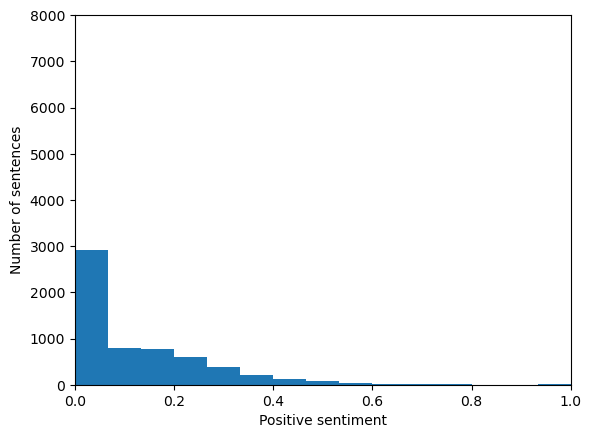

In [91]:
positive_sent = []
#iterate through the sentences, get polarity scores, choose a value
[positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in doc.sents]
# 可以改成
# for sent in doc.sents:
#   positive_sent.append(analyzer.polarity_scores(sent.text)['pos'])

plt.hist(positive_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,8000])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of sentences')
plt.show()

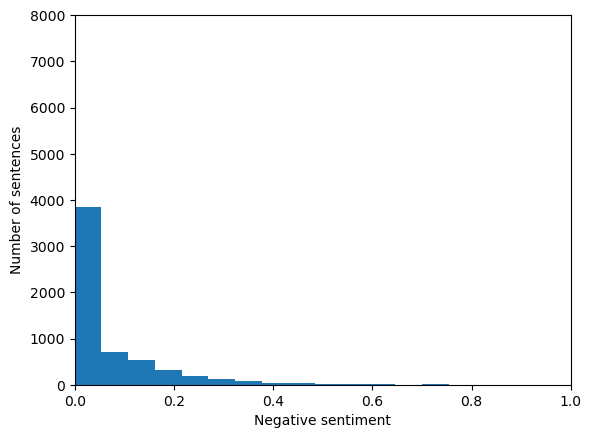

In [92]:
negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in doc.sents]
plt.hist(negative_sent,bins=15)
plt.xlim([0,1])
plt.ylim([0,8000])
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')
plt.show()

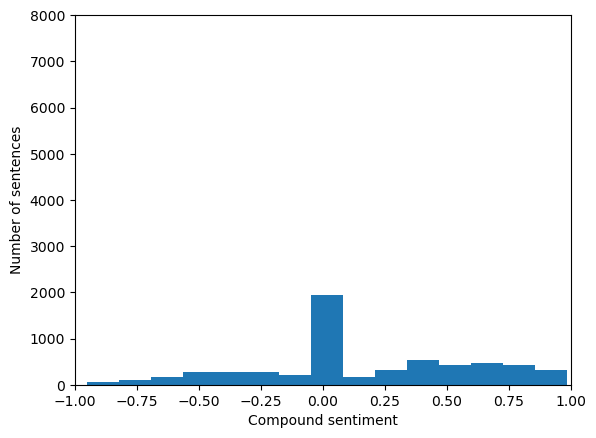

In [93]:
total_sent = []
[total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
plt.hist(total_sent,bins = 15)
plt.xlim([-1,1])
plt.ylim([0,8000])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences')
plt.show()

In [94]:
sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
# 可以改成
# sents = []
# for sent in doc.sents:
#   compound_score = analyzer.polarity_scores(sent.text)['compound']
#   sents.append(compound_score)

# np.array(sents)>=0.05 得到一个布尔数组，例如：[True, True, False, False, False, False]
# NumPy 中，布尔值 True 被视为 1，False 被视为 0。
# 使用 sum() 对布尔数组求和，即可统计满足条件的值的数量。
print('Number of positive sentences:',sum(np.array(sents)>=0.05))
print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))

Number of positive sentences: 2734
Number of negative sentences: 1343
Number of neutral sentences: 1872


#### Most of the sentences are quite neutral in sentiment. This is not the case when working with data from other sources (e.g., in social media opinions are strong and polarized (bimodal distribution)).

# Task 2: Document classification: Can we detect paragraphs from Frankenstein?

这段代码的作用是**使用 `nltk` 加载指定目录下的文本文件**，并初始化一个用于处理文本的 `PlaintextCorpusReader` 对象，方便后续对文本进行分析。以下是逐步解析：

- **`PlaintextCorpusReader`**：

  - NLTK 中的一个类，用于读取目录下的普通文本文件。

  - 它将每个文件视为一个语料库，可以通过指定的正则表达式匹配文件名，并将其加载。

**1.查看 `PlaintextCorpusReader` 的帮助信息**
```python
?PlaintextCorpusReader
```

- 这行代码是查看 Python 对象的帮助信息的快捷方式。

- 它会显示 `PlaintextCorpusReader` 的文档，告诉你它有哪些方法、参数以及功能。

**2. 初始化 `PlaintextCorpusReader`**
```python
our_books = PlaintextCorpusReader(corpus_root, '.*.txt')
```

- **`corpus_root`**：

  - 表示文本文件所在的目录路径。

  - 假设 `corpus_root = './books/'`，则它会读取 `./books/` 目录中的文件。

- **`'.*.txt'`**：

  - 这是一个正则表达式，表示匹配所有以 `.txt` 结尾的文件。

- **返回值**：
  - `PlaintextCorpusReader` 对象 `our_books`，它可以用来访问文件内容、句子、段落等。

**3. 查看加载的文件**
```python
print(our_books.fileids())
```

- **`our_books.fileids()`**：

  - 方法 `fileids()` 会返回一个列表，包含目录中所有被加载的文件名。

  - 例如：
    ```python
    ['frankenstein.txt', 'dracula.txt']
    ```

In [95]:
# Let's load our corpus via NLTK this time
from nltk.corpus import PlaintextCorpusReader
?PlaintextCorpusReader
our_books = PlaintextCorpusReader(corpus_root, '.*.txt')
print(our_books.fileids())

['DRACULA.txt', 'Frankenstein.txt', 'Moby_Dick.txt', 'PRIDE_AND_PREJUDICE.txt']


Init signature:
PlaintextCorpusReader(
    root,
    fileids,
    word_tokenizer=WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL),
    sent_tokenizer=None,
    para_block_reader=<function read_blankline_block at 0x000001EC09507060>,
    encoding='utf8',
)
Docstring:     
Reader for corpora that consist of plaintext documents.  Paragraphs
are assumed to be split using blank lines.  Sentences and words can
be tokenized using the default tokenizers, or by custom tokenizers
specified as parameters to the constructor.

This corpus reader can be customized (e.g., to skip preface
sections of specific document formats) by creating a subclass and
overriding the ``CorpusView`` class variable.
Init docstring:
Construct a new plaintext corpus reader for a set of documents
located at the given root directory.  Example usage:

    >>> root = '/usr/local/share/nltk_data/corpora/webtext/'
    >>> reader = PlaintextCorpusReader(root,

### We will segment the books into equally long chunks

**1. 定义 `get_chunks` 函数**
```python
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
```

- **功能**：将列表 `l` 按照长度为 `n` 的块分割。

- **输入**：

  - `l`：要分割的列表。

  - `n`：每块的大小。

- **输出**：使用 `yield` 返回分块结果（生成器）。

- **示例**：
  ```python
  l = [1, 2, 3, 4, 5, 6]
  n = 2
  chunks = list(get_chunks(l, n))  # [[1, 2], [3, 4], [5, 6]]
  ```

**2. 字典 `book_id`**
```python
book_id = {f: n for n, f in enumerate(our_books.fileids())}
```

- **功能**：为每本书分配一个唯一的编号。

- **输入**：

  - `our_books.fileids()`：返回所有加载的书籍文件名。

- **输出**：

  - `book_id`：一个字典，键是文件名，值是编号。

- **示例**：
  ```python
  our_books.fileids() = ['book1.txt', 'book2.txt']
  book_id = {'book1.txt': 0, 'book2.txt': 1}
  ```

**3. 初始化变量**
```python
chunks = list()
chunk_class = list()
limit = 500
size = 50
```

- **`chunks`**：保存所有书籍的分块数据，每个块是一个字符串。

- **`chunk_class`**：保存每个块的原始书籍编号，用于后续分类任务。

- **`limit`**：每本书最多提取的块数量。

- **`size`**：每个块包含的句子数量。

**4. 遍历所有书籍**
```python
for f in our_books.fileids():
    sentences = our_books.sents(f)
    print(f,":")
    print('Number of sentences:',len(sentences))
```

- **`our_books.fileids()`**：获取每本书的文件名。

- **`our_books.sents(f)`**：获取书籍 `f` 中的所有句子，返回一个列表，句子中的每个词是一个 token。

- **打印信息**：输出书籍名和句子数量。


**5. 按句子分块**
```python
chunks_of_sents = [x for x in get_chunks(sentences, size)]
```

- 使用 `get_chunks` 函数将句子列表 `sentences` 按 `size` （50）进行分块。

- **`chunks_of_sents`** 是一个列表，每个元素是一个包含 50 个句子的列表。

**6. 处理块，合并为字符串**
```python
chs = list()
for c in chunks_of_sents:
    grouped_chunk = list()
    for s in c:
        grouped_chunk.extend(s)
    chs.append(" ".join(grouped_chunk))
```

- **功能**：将块中的句子转换为单个字符串块。

- **操作步骤**：

  1. 遍历每个块 `c`（`c` 是一个句子列表，句子是 token 列表）。

  2. 将块中的所有句子合并为一个列表 `grouped_chunk`。

  3. 用 `" ".join()` 将词用空格拼接成字符串。

  4. 将字符串块追加到 `chs`。

**7. 统计分块数量**
```python
print("Number of chunks:", len(chs), '\n')
```

- 打印当前书籍的总分块数量。

**8. 限制块数量并记录信息**
```python
chunks.extend(chs[:limit])
chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])
```

- **限制块数量**：
  - `chs[:limit]`：只保留前 `limit`（500）个块。

  - `chunks.extend()`：将这些块添加到总块列表 `chunks` 中。

- **记录块的书籍编号**：

  - `[book_id[f] for _ in range(len(chs[:limit]))]`：

    - 生成一个列表，长度为当前块数量，每个元素为当前书籍的编号。

    - 添加到 `chunk_class` 中。

**代码输出示例**

假设：
- 有两本书，分别是 `book1.txt` 和 `book2.txt`。
- 每本书有 600 句，每块包含 50 句，限制为 500 块。

输出：
```plaintext
book1.txt :
Number of sentences: 600
Number of chunks: 12

book2.txt :
Number of sentences: 600
Number of chunks: 12
```

最终：
- `chunks` 包含两个书籍的块，最多 500 个。
- `chunk_class` 包含每个块的对应书籍编号。

In [96]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


# Get the data
book_id = {f:n for n,f in enumerate(our_books.fileids())} # dictionary of books

chunks = list()
chunk_class = list() # this list contains the original book of the chunk, for evaluation

limit = 500 # how many chunks total
size = 50 # how many sentences per chunk/page

for f in our_books.fileids():
    sentences = our_books.sents(f)
    print(f,":")
    print('Number of sentences:',len(sentences))
    
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()
    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

DRACULA.txt :
Number of sentences: 9303
Number of chunks: 187 

Frankenstein.txt :
Number of sentences: 3378
Number of chunks: 68 

Moby_Dick.txt :
Number of sentences: 9609
Number of chunks: 193 

PRIDE_AND_PREJUDICE.txt :
Number of sentences: 6055
Number of chunks: 122 



### Representing the chunks with bag-of-words

**1. 初始化 `CountVectorizer`**
```python
vectorizer = CountVectorizer()
```
- **`CountVectorizer`** 是 scikit-learn 中的工具，用于将文本转化为词袋模型（bag-of-words）的特征表示。

- **词袋模型**：每个文档被表示为一个稀疏矩阵，矩阵的每一列代表一个词，值是词在文档中出现的次数。

**2. 可选参数 `min_df`**
```python
# vectorizer = CountVectorizer(min_df = 2)
```
- 如果启用 `min_df=2`，仅保留在至少 2 个文档中出现的词。这可以减少特征的数量，避免过于稀疏的矩阵，提升计算效率。

**3. 创建 Bag-of-Words 特征**
```python
X = vectorizer.fit_transform(chunks)
```

- **`fit_transform(chunks)`**：

  - `fit`：学习词汇表，将所有文本块的所有词汇提取成一个唯一词的集合。

  - `transform`：将 `chunks` 转换为稀疏矩阵，矩阵的形状为 (文档数, 特征数)。

  - 每个文本块（chunk）对应矩阵中的一行，每个词对应一列。

**4. 打印特征矩阵的维度**
```python
print('Number of samples:', X.toarray().shape[0])
print('Number of features:', X.toarray().shape[1])
```
- `X.toarray().shape[0]`：文档数，即 `chunks` 的数量。
- `X.toarray().shape[1]`：特征数，即提取出的唯一词汇总数。

**5. 生成目标变量 Y**
```python
Y = np.array(chunk_class) == 1
Y = Y.astype(int)
```
- `chunk_class` 是之前生成的块所属书籍的编号。

- **目标变量 `Y`**：

  - 判断 `chunk_class` 是否等于 `1`（即 `Frankenstein` 的编号）。

  - 如果是 `Frankenstein` 的块，标记为 `1`；否则为 `0`。

- `astype(int)`：将布尔值（`True/False`）转化为整型（`1/0`）。

**6. 数据打乱**
```python
X, Y = shuffle(X, Y, random_state=0)
```
- 使用 `shuffle` 打乱特征 `X` 和目标变量 `Y` 的顺序。

- 设置 `random_state=0` 确保每次打乱的结果相同（可复现性）。

**7. 划分训练集和测试集**
```python
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
```
- **`train_test_split`**：将数据集随机拆分为训练集和测试集。

- 参数：

  - `X`：特征矩阵（文本块的词袋表示）。

  - `Y`：目标变量（是否属于 `Frankenstein`）。

  - `test_size=0.2`：测试集占总数据的 20%，训练集占 80%。

  - `random_state=42`：固定随机种子，保证可复现性。

- 输出：

  - `X_train` 和 `Y_train`：用于训练模型的数据。

  - `X_test` 和 `Y_test`：用于评估模型性能的数据。

In [97]:
vectorizer = CountVectorizer()

#initialize and specify minumum number of occurences to avoid untractable number of features
#vectorizer = CountVectorizer(min_df = 2) if we want high frequency

#create bag of words features
X = vectorizer.fit_transform(chunks)

print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])

#mask and convert to int Frankenstein
Y = np.array(chunk_class) == 1
Y = Y.astype(int)  

#shuffle the data
X, Y = shuffle(X, Y, random_state=0)

#split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of samples: 570
Number of features: 23116


### Let's fit the regularized logistic regression. We will crossvalidate the regularization parameter on the training set.

**1. 正则化的逻辑回归**
```python
clf = LogisticRegression(random_state=0, solver='lbfgs', C=c)
```

- **正则化参数 \( C \)**：
  - 参数 `C` 是正则化参数的倒数（\( C = 1 / \lambda \)）。
  - **正则化作用**：在模型中防止过拟合：
    - \( C \) 越小，正则化强度越高（强烈惩罚大权重）。
    - \( C \) 越大，正则化强度越弱（接近普通逻辑回归）。

- **参数含义**：
  - `random_state=0`：固定随机种子，确保结果可复现。
  - `solver='lbfgs'`：使用 L-BFGS 算法优化，这是适合小到中等规模数据的优化器。

**2. 网格搜索（Grid Search）**
```python
grid = [0.01, 0.1, 1, 10, 100, 1000, 10000]
```

- 定义了一个包含多个 \( C \) 值的列表 `grid`，用于测试不同的正则化强度。

**3. 交叉验证**
```python
scores = cross_val_score(clf, X_train, Y_train, cv=10)
```

- **交叉验证（Cross-validation）**：
  - 将训练集 `X_train` 和 `Y_train` 分成 10 个子集（`cv=10`）。
  - 每次从 10 个子集中选出一个作为验证集，其余 9 个作为训练集，重复 10 次。
  - 计算每次验证的分数（如准确率 `accuracy`），得到 10 个分数。

- **返回值 `scores`**：
  - 一个长度为 10 的数组，包含每次验证的分数（准确率）。

**4. 记录平均准确率**
```python
accs.append(np.mean(scores))
```

- 对每个正则化参数 \( C \)，取 10 次交叉验证分数的平均值，作为模型的总体性能表现。
- `accs`：一个列表，记录了不同 \( C \) 值下模型的平均准确率。

In [98]:
accs = []

#the grid of regularization parameter 
grid = [0.01,0.1,1,10,100,1000,10000]

for c in grid:
    
    #initialize the classifier
    clf = LogisticRegression(random_state=0, solver='lbfgs',C = c)
    
    #crossvalidate
    scores = cross_val_score(clf, X_train,Y_train, cv=10)
    accs.append(np.mean(scores))

**1. `plt.plot(accs)`**
- `plt.plot(accs)` 默认的横坐标是索引（从 0 到 `len(accs)-1`），纵坐标是 `accs` 的值（对应每个正则化参数的平均准确率）。
- 因此，画出的图横坐标默认是数字 0, 1, 2, ...。

**2. `plt.xticks(range(len(grid)), grid)`**
- **`range(len(grid))`**：
  - 横坐标的索引范围，与 `grid` 和 `accs` 的长度一致。
  - 每个点的横坐标位置为 0, 1, 2, ...。

- **`grid`**：
  - 替换默认的横坐标数字为正则化参数 `C` 的值。
  - 每个 `C` 值与 `accs` 中的对应值匹配。

- **效果**：
  - 原来的横坐标是索引（0, 1, 2, ...），现在变成了对应的 `grid` 中的正则化参数值（如 0.01, 0.1, 1, ...）。

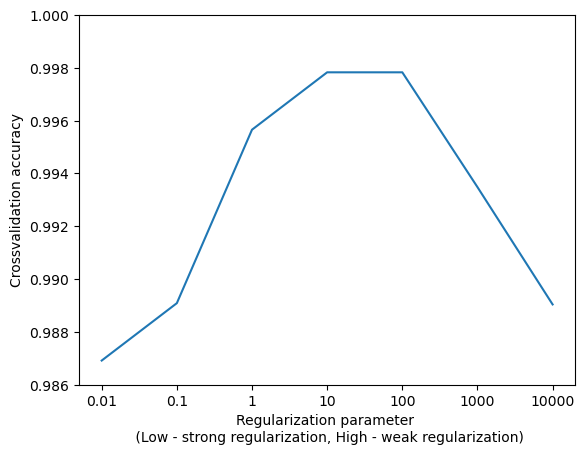

In [99]:
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')
plt.ylim([0.986,1])
plt.show()

### Let's train again, on the entire training set, with the chosen regularization parameter. We will test on the test set

**测试集预测**
```python
print('Accuracy:', clf.score(X_test, Y_test))
```

- **`.score(X_test, Y_test)`**：
  - 直接计算模型在测试集上的 **准确率（Accuracy）**。
  - **准确率公式**：
    \[
    \text{Accuracy} = \frac{\text{正确预测的样本数}}{\text{总样本数}}
    \]
  - 测试集数据：
    - `X_test`：测试集的特征。
    - `Y_test`：测试集的真实标签。
  - 逻辑回归模型会对 `X_test` 的每个样本生成预测类别，然后将预测值与真实值 `Y_test` 进行比较，计算预测正确的比例。

In [100]:
clf = LogisticRegression(random_state=0, solver='lbfgs',C = 10).fit(X_train,Y_train)

#predict on the test set
print('Accuracy:',clf.score(X_test,Y_test))

Accuracy: 0.9824561403508771


### What features characterize Frankenstein? BOW are interpretable!

**1. 提取逻辑回归的系数**
```python
coefs = clf.coef_[0]
```

- **`clf.coef_`**：
  - `clf.coef_` 是逻辑回归模型中每个特征的回归系数。
  - 逻辑回归是一个线性模型，对于每个特征，模型会学习一个权重（系数），用于预测目标变量。
  - `coef_` 是一个二维数组，形状为 `(1, n_features)`，这里 `[0]` 表示提取第一类的系数。

- **作用**：
  - 每个特征的系数表示它对分类任务的重要性：
    - **正系数**：特征与目标值（`Frankenstein` 属于该类）正相关。
    - **负系数**：特征与目标值负相关。

**2. 找出最大的 20 个特征的索引**
```python
top_three = np.argpartition(coefs, -20)[-20:]
```

- **`np.argpartition()`**：
  - `argpartition` 是 NumPy 中用于高效提取最小或最大的几个元素索引的方法。
  - 这里 `-20` 表示找出系数值中最大的 20 个元素的索引。

- **作用**：
  - `top_three` 是一个包含 20 个索引的数组，对应模型中 20 个对分类最重要的特征。

**3. 获取特征名称**
```python
np.array(vectorizer.get_feature_names())[top_three]
```

- **`vectorizer.get_feature_names_out()`**：
  - `get_feature_names()` 是 `CountVectorizer` 的方法，用于返回所有特征（词汇）的名称。
  - 每个特征对应 Bag-of-Words 模型中的一列（词汇）。
  - 返回的是一个包含所有词汇的列表，长度为特征数（`n_features`）。

- **`np.array(vectorizer.get_feature_names_out())`**：
  - 将词汇列表转换为 NumPy 数组，以便通过索引提取。

- **`[top_three]`**：
  - 使用之前提取的索引数组 `top_three` 获取对应的特征名称。
  - 输出是一个包含 20 个词汇的数组，表示对分类任务最重要的词。

**输出示例**
假设 `vectorizer.get_feature_names_out()` 返回的词汇表为：
```python
['monster', 'science', 'love', 'fear', 'creature', 'frankenstein', 'death', 'life', 'electricity', 'creation', ...]
```

假设提取的前 20 个特征索引是：
```python
top_three = [1, 4, 5, 7, 9, ...]
```

输出结果为：
```python
['science', 'creature', 'frankenstein', 'life', 'creation', ...]
```

In [101]:
coefs=clf.coef_[0]
top_three = np.argpartition(coefs, -20)[-20:]

print(np.array(vectorizer.get_feature_names_out())[top_three])

['frankenstein' 'towards' 'death' 'which' 'by' 'had' 'of' 'will' 'misery'
 'but' 'father' 'my' 'yet' 'and' 'who' 'creature' 'justine' 'this' 'me'
 'poor']


### We can perfectly predict paragraphs from Frankenstein! We saw issues of high dimensionality when using bag of words (more features than samples) and how regularization helps.

### Alternative text representation: word emdeddings, pretrained on intergraded in Spacy (300-dimensional word vectors trained on Common Crawl with GloVe.) Depending on the application, might be suitable or not

**1. 预训练的词嵌入（Word Embeddings）**
```python
nlp(example).vector
```

- **`.vector`**：
  - `vector` 是 `spaCy` 内置的预训练词嵌入，默认使用 GloVe（300维）。
  - 它为整个文本段提供了一个向量表示，这是通过对段落中所有词向量的加权平均计算得到的。

**2. 为什么用词嵌入？**
词嵌入将每个单词映射为一个稠密向量（dense vector），这些向量具有以下特性：
- **语义相似性**：相似意义的词会在向量空间中彼此接近。
- **上下文无关**：默认情况下，`spaCy` 提供的 GloVe 词向量是上下文无关的（与 Transformer 模型不同）。

**3. 代码功能**
```python
print('Embedding representation:', list((nlp(example).vector)[0:10]), '...')
```

- **`nlp(example).vector`**：
  - 将文本 `example` 转换为一个 300 维的词向量。
  - 示例向量的长度固定为 300，无论输入的文本长度是多少。

- **`[0:10]`**：
  - 截取向量的前 10 个值，方便展示。

- **`list()`**：
  - 将截取的向量部分转换为列表形式，便于打印输出。

- **输出示例**：
  - 如果向量值为 `[0.1, -0.2, 0.3, ..., 0.05]`，则输出类似：
    ```plaintext
    Embedding representation: [0.1, -0.2, 0.3, 0.4, -0.1, 0.05, 0.2, -0.3, 0.6, 0.7] ...
    ```

In [102]:
print(example,'\n')
print('Embedding representation:',list((nlp(example).vector)[0:10]),'...')

I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 

Embedding representation: [0.20092034, -0.076974384, -0.23990451, -0.042965, 0.06303602, 0.0937523, 0.36673704, -0.08795012, 0.37766436, -0.11488456] ...


# Task 3: Topic detection

In [103]:
# Get the chunks again (into smaller chunks)
book_id = {f:n for n,f in enumerate(our_books.fileids())} # dictionary of books
chunks = list()
chunk_class = list() # this list contains the original book of the chunk, for evaluation

limit = 60 # how many chunks total
size = 50 # how many sentences per chunk/page

for f in our_books.fileids():
    sentences = our_books.sents(f)
    print(f)
    print('Number of sentences:',len(sentences))
    
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()
    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

DRACULA.txt
Number of sentences: 9303
Number of chunks: 187 

Frankenstein.txt
Number of sentences: 3378
Number of chunks: 68 

Moby_Dick.txt
Number of sentences: 9609
Number of chunks: 193 

PRIDE_AND_PREJUDICE.txt
Number of sentences: 6055
Number of chunks: 122 



**1. 遍历处理文档（文本块）**
```python
for doc in nlp.pipe(chunks, n_process=5, batch_size=10):
```

- **`nlp.pipe`**：
  - `spaCy` 提供的并行处理方法，可以批量处理文本，提高速度。
  - 参数：
    - `chunks`：要处理的文本块列表。
    - `n_process=5`：开启 5 个并行进程。
    - `batch_size=10`：每次处理 10 个文本块。

- **`doc`**：
  - 每个 `doc` 是 `spaCy` 的 `Doc` 对象，包含了分词、词性标注、命名实体识别等信息。

**2. 提取命名实体**
```python
ents = doc.ents  # Named entities
```
- **`doc.ents`**：
  - 提取当前文档的所有命名实体（Named Entities），如人名、地名、日期等。
  - 每个实体是一个 `Span` 对象。

**3. 文本清理**
```python
doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
```
- 逐个处理文档中的单词（`token`），完成以下操作：
  1. **词形还原（Lemmatization）**：
     - 使用 `token.lemma_` 获取单词的词根形式。例如，`running` 变为 `run`。
  2. **过滤非字母**：
     - 使用 `token.is_alpha` 只保留字母，去掉数字、标点符号等。
  3. **去除停止词**：
     - 使用 `not token.is_stop` 去掉常见的无意义单词。

结果是一个只包含有意义单词的列表。

**4. 进一步过滤**
```python
doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
```
- 再次过滤，完成以下操作：
  1. **自定义停止词过滤**：
     - 如果单词在 `STOPWORDS` 中（常用停用词列表），则移除。
  2. **长度限制**：
     - 去掉长度小于 3 的单词（长度过短的词通常意义不大）。

**5. 添加命名实体**
```python
doc.extend([str(entity) for entity in ents if len(entity) > 1])
```
- 提取的命名实体也添加到文档中，但只保留长度大于 1 的实体（忽略单字实体）。
- `str(entity)`：将命名实体转换为字符串。

**6. 保存结果**
```python
processed_docs.append(doc)
```
- 将清理后的文档（一个列表，包含处理后的单词）添加到 `processed_docs` 列表中。

**7. 输出结果**
```python
docs = processed_docs
del processed_docs
```
- `processed_docs` 中保存的是所有清理后的文档。
- 将其赋值给 `docs`，并删除 `processed_docs`（释放内存）。

In [104]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(chunks, n_process=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

这段代码的目的是在预处理后的文档中加入 **二元短语（bigrams）**，即由两个相邻单词组成的词组。例如，"New York" 会被识别为一个二元短语，并在原文档中作为一个新词添加进去。

**1. 什么是二元短语（Bigrams）？**
二元短语是由两个相邻的单词组成的组合，比如：
- 在句子 "I love machine learning" 中，可能的二元短语是：
  - `I love`
  - `love machine`
  - `machine learning`

**2. `gensim.models.phrases.Phrases`**
```python
bigram = Phrases(docs, min_count=15)
```

- **功能**：
  - `Phrases` 是 Gensim 中的模块，用于识别文本中的常见二元短语。
  - 它会扫描 `docs`（文档列表）中的单词组合，计算它们的共现频率，发现高频短语。

- **参数**：
  - `min_count=15`：
    - 仅识别在所有文档中出现次数大于或等于 15 次的二元短语。
    - 例如，如果 "New York" 在文档中出现了 20 次，它会被识别为一个短语。
    - 如果出现次数少于 15 次，则不会被视为短语。

- **结果**：
  - `bigram` 是一个可以用于检测二元短语的对象。

**3. 遍历文档**
```python
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
```

- **逐步解析**：
  - 遍历文档 `docs` 中的每个文档（`idx` 表示文档索引）。
  - 对每个文档，使用 `bigram[docs[idx]]` 检测文档中是否包含二元短语。
    - `bigram[docs[idx]]` 返回的是一个新的单词列表，包含原始单词和检测到的二元短语。
  - 检测到的二元短语用下划线 `_` 连接，例如 `"New York"` 会变为 `"New_York"`。

- **`if '_' in token`**：
  - 检查当前 `token` 是否为二元短语（是否包含下划线 `_`）。
  - 如果是，将该二元短语加入当前文档的单词列表中。

- **结果**：
  - 如果文档中检测到常见短语，这些短语会被添加到文档中。例如：
    - 原始文档：`["new", "york", "city"]`
    - 检测到短语 `"New_York"`：
      - 更新后文档：`["new", "york", "city", "New_York"]`

**4. 示例**

**输入文档（预处理后的 `docs`）**
```python
docs = [
    ["new", "york", "city", "is", "beautiful"],
    ["i", "live", "in", "new", "york"],
    ["new", "york", "times", "is", "a", "famous", "newspaper"]
]
```

**识别短语**
- 假设 `min_count=2`，程序会检测到以下二元短语：
  - `"new_york"`（出现次数 >= 2）。

**处理过程**
- 第一篇文档：
  - 输入：`["new", "york", "city", "is", "beautiful"]`
  - 检测到短语 `"new_york"`。
  - 更新：`["new", "york", "city", "is", "beautiful", "new_york"]`

- 第二篇文档：
  - 输入：`["i", "live", "in", "new", "york"]`
  - 检测到短语 `"new_york"`。
  - 更新：`["i", "live", "in", "new", "york", "new_york"]`

**输出文档**
```python
docs = [
    ["new", "york", "city", "is", "beautiful", "new_york"],
    ["i", "live", "in", "new", "york", "new_york"],
    ["new", "york", "times", "is", "a", "famous", "newspaper", "new_york"]
]
```

In [105]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

这段代码的目的是对文档（`docs`）进行预处理，生成用于文本建模（例如 LDA 主题建模）的 **词袋表示（Bag-of-Words, BOW）**，并过滤掉太频繁或太稀有的词汇，以提高模型的性能。

**1. 创建词典（Dictionary）**
```python
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
```

- **`Dictionary`**:
  - Gensim 的 `Dictionary` 类是一个轻量级的词汇表。
  - 它会扫描所有文档（`docs`），将所有出现的词汇（token）映射为唯一的整数 ID。
  - 词典同时记录每个单词的出现频率。
  
- **作用**：
  - 创建一个映射表，将每个单词与一个唯一的整数 ID 关联。
  - 例如：
    ```plaintext
    doc1 = ["apple", "banana", "apple"]
    doc2 = ["banana", "carrot"]
    Dictionary = { "apple": 0, "banana": 1, "carrot": 2 }
    ```

**2. 过滤高频和低频词**
```python
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
```

- **`filter_extremes()`**:
  - 去掉出现频率过高或过低的单词，以减少噪声和特征数。
  
- **参数**：
  - `no_below=min_wordcount`:
    - 去掉在所有文档中出现次数少于 `min_wordcount` 次的单词（稀有词）。
    - 例如，如果 `min_wordcount=5`，在所有文档中出现次数少于 5 次的单词会被移除。
  - `no_above=max_freq`:
    - 去掉出现在所有文档中比例超过 `max_freq` 的单词（高频词）。
    - 例如，如果 `max_freq=0.5`，出现在 50% 或以上文档中的单词会被移除。

- **过滤后的效果**：
  - 保留的信息量高的单词（即适度出现的单词）。
  - 避免噪声：
    - 稀有词通常只对个别文档有意义，无法帮助模型泛化。
    - 高频词（如 "the", "is"）通常语义信息较少。

**3. 生成词袋表示（Bag-of-Words, BOW）**
```python
corpus = [dictionary.doc2bow(doc) for doc in docs]
```

- **`doc2bow(doc)`**:
  - 将每个文档转换为词袋表示（BOW），即单词 ID 和对应的词频。
  - 每个文档的 BOW 表示为一个列表，列表中的每一项是一个 `(单词ID, 词频)` 的元组。

- **BOW 示例**：
  假设词典如下：
  ```plaintext
  { "apple": 0, "banana": 1, "carrot": 2 }
  ```
  - 文档 `["apple", "apple", "banana"]` 转换为：
    ```plaintext
    [(0, 2), (1, 1)]
    ```
    这里 `(0, 2)` 表示单词 "apple" 的 ID 是 0，出现了 2 次。

- **`corpus`**:
  - 包含所有文档的 BOW 表示。

**4. 打印结果**
```python
print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))
```

- **`len(dictionary)`**：
  - 打印过滤后的词典中剩余的唯一单词数量。

- **`len(corpus)`**：
  - 打印语料库中文档的总数。

**示例**

**输入文档（docs）**
```python
docs = [
    ["apple", "banana", "apple", "orange"],
    ["banana", "carrot", "carrot"],
    ["apple", "banana", "carrot", "apple", "apple"]
]
```

**过滤条件**
- `min_wordcount=2`：出现次数少于 2 的词被移除。
- `max_freq=0.5`：出现在超过 50% 文档中的词被移除。

**生成词典**
```plaintext
{ "banana": 0, "carrot": 1 }
```

**生成语料库（corpus）**
```python
corpus = [
    [(0, 1)],
    [(0, 1), (1, 2)],
    [(0, 1), (1, 1)]
]
```

**输出结果**
```plaintext
Number of unique tokens: 2
Number of chunks: 3
```

In [106]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 3087
Number of chunks: 240


这段代码的目的是利用 Gensim 的 `LdaMulticore` 模型实现 **LDA（Latent Dirichlet Allocation）**，即潜在狄利克雷分布主题建模。LDA 是一种常用的无监督学习方法，用于从文档中提取主题。

**1. 导入 `LdaMulticore`**
```python
from gensim.models import LdaMulticore
```

- **`LdaMulticore`**:
  - 是 Gensim 中实现 LDA 的多线程版本。
  - 它可以利用多核 CPU 并行化处理，加快训练速度，尤其是对于大规模语料库。
  - 如果不需要并行，可以使用 `LdaModel`（单线程版本）。

**2. 传递参数**
```python
params = {'passes': 10, 'random_state': seed}
```

- **`params`**:
  - 一个字典，用于存储模型的超参数。
  - 参数说明：
    - `passes`：模型训练语料的次数。值越高，模型会多次迭代优化，从而收敛更好。
    - `random_state`：随机种子，用于保证模型的结果可复现。
  - `seed` 是预先定义的随机种子。

**3. 模型初始化**
```python
model = LdaMulticore(
    corpus=corpus,
    num_topics=4,
    id2word=dictionary,
    workers=6,
    passes=params['passes'],
    random_state=params['random_state']
)
```

- **模型参数**：
  1. **`corpus`**：
     - 输入的语料库，格式是 Gensim 的 **Bag-of-Words（BOW）表示**。
     - 每篇文档由单词 ID 和词频组成，例如：
       ```plaintext
       [(0, 2), (1, 1)]
       ```
     - 表示单词 ID 为 0 的单词出现了 2 次，单词 ID 为 1 的单词出现了 1 次。
  2. **`num_topics=4`**：
     - 设置要提取的主题数量为 4。
     - 模型会假设文档中的内容可以由 4 个主题表示。
  3. **`id2word=dictionary`**：
     - 词典，映射单词 ID 到单词本身。
     - 用于将主题中出现的单词 ID 翻译回原始单词。
  4. **`workers=6`**：
     - 多线程参数，使用 6 个线程并行化训练。
     - 如果设置为 1，则模型以单线程运行。
  5. **`passes=params['passes']`**：
     - 设置语料库的迭代次数（即遍历语料的次数）。
     - 每次迭代，模型会更新主题分布，增加模型收敛的可能性。
  6. **`random_state=params['random_state']`**：
     - 随机种子，用于控制模型初始化和抽样的随机性，保证结果可复现。

In [107]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

`model.show_topics(num_words=5)` 是 Gensim 提供的一种方法，用于 **显示主题模型中每个主题的主要单词**，以及这些单词的权重。以下是详细解释：

**1. `model.show_topics` 的作用**

- **功能**：显示主题模型中的主题及其相关的单词和权重。
- **参数**：
  - `num_words=5`：每个主题中展示的单词数量，默认值为 10。设置为 5 就是每个主题只显示 5 个最重要的单词。
  - `num_topics`（可选）：要显示的主题数量。如果不指定，默认显示所有主题。

- **输出**：
  - 一个列表，包含主题编号和主题中主要单词的字符串表示及其权重。

**2. 输出结果解释**

如果输出如下：
```plaintext
主题 0: 0.3*'science' + 0.2*'data' + 0.1*'research' + 0.1*'analysis' + 0.1*'machine'
主题 1: 0.4*'book' + 0.3*'author' + 0.2*'literature' + 0.1*'reading' + 0.1*'novel'
主题 2: 0.5*'apple' + 0.3*'fruit' + 0.2*'banana'
```

- **主题 0**：
  - 包含 "science", "data", "research"，可以推测是与科学、数据分析相关的主题。
- **主题 1**：
  - 包含 "book", "author", "literature"，可能是与书籍或文学相关的主题。
- **主题 2**：
  - 包含 "apple", "fruit", "banana"，可能是与水果相关的主题。

In [108]:
model.show_topics(num_words=5)

[(0,
  '0.008*"father" + 0.006*"life" + 0.005*"Elizabeth" + 0.005*"feeling" + 0.004*"love"'),
 (1,
  '0.007*"room" + 0.006*"door" + 0.006*"sleep" + 0.006*"Lucy" + 0.005*"old"'),
 (2,
  '0.017*"whale" + 0.011*"ship" + 0.010*"sea" + 0.008*"Queequeg" + 0.008*"old"'),
 (3,
  '0.016*"Elizabeth" + 0.012*"Darcy" + 0.011*"Bingley" + 0.010*"Miss" + 0.009*"Mrs"')]

`model.show_topic(1, 20)` 是 Gensim 中用于查看 **特定主题** 的主要单词及其权重的方法。

**1. 功能**

- 该方法显示某一个特定主题中的主要单词及其权重，而不是像 `show_topics()` 那样显示多个主题。
- **参数说明**：
  - `1`：表示要查看的主题编号。
  - `20`：表示希望列出的单词数量（即该主题中最重要的前 20 个单词）。

**2. 输出格式**

- 返回一个列表，其中每个元素是一个元组 `(word, weight)`。
  - `word`：主题中的单词。
  - `weight`：该单词在主题中的权重。
  - 权重表示单词在该主题中所占的比例，值越大，表示该单词越重要。

**3. 参数**

- **`topicid`**：
  - 表示要查看的主题编号，从 0 开始计数。
  - 例如，如果模型中有 4 个主题，则有效值为 0 到 3。
- **`topn`**：
  - 表示要显示的主题单词数量。
  - 如果设置为 20，则显示前 20 个最重要的单词。

In [109]:
model.show_topic(1,20)

[('room', 0.0069176685),
 ('door', 0.0064798663),
 ('sleep', 0.0059972634),
 ('Lucy', 0.005515727),
 ('old', 0.0049927966),
 ('Count', 0.0048010307),
 ('window', 0.0044715963),
 ('dear', 0.004363028),
 ('fear', 0.0042384374),
 ('open', 0.003989997),
 ('ask', 0.0039044884),
 ('light', 0.0036928435),
 ('try', 0.0035804284),
 ('sit', 0.00353518),
 ('run', 0.003509862),
 ('write', 0.003474833),
 ('fall', 0.0034288822),
 ('lie', 0.0034027952),
 ('bed', 0.0032984412),
 ('pass', 0.0032581566)]

**1. 背景**
- **`model[corpus[0]]`**：
  - 这是 LDA 模型的一个调用方式。
  - 它返回了 **第一个文档（`corpus[0]`）在主题空间中的分布**。
  - 每个文档的主题分布由一个列表表示，其中每个元素是一个元组 `(主题编号, 主题权重)`。
  - 示例输出可能如下：
    ```python
    [(0, 0.1), (1, 0.7), (2, 0.2)]
    ```
    这表示：
    - 主题 0 的权重是 0.1
    - 主题 1 的权重是 0.7
    - 主题 2 的权重是 0.2

**2. 排序文档的主题分布**
```python
sorted(model[corpus[0]], key=lambda x: x[1], reverse=True)
```

- **`sorted`**：
  - 用于对文档的主题分布列表进行排序。

- **`key=lambda x: x[1]`**：
  - 指定排序的依据。
  - `x` 表示主题分布中的每个元组 `(主题编号, 权重)`。
  - `x[1]` 是主题的权重，因此排序时会根据主题权重进行排序。

- **`reverse=True`**：
  - 设置为 `True` 表示降序排列（从高到低）。
  - 权重最大的主题会排在最前面。

In [110]:
sorted(model[corpus[0]],key=lambda x:x[1],reverse=True)

[(1, 0.9972272)]

In [111]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [112]:
# assignment
sent_to_cluster = list()
for n,doc in enumerate(corpus):
    if doc:
        cluster = max(model[doc],key=lambda x:x[1])
        sent_to_cluster.append(cluster[0])

In [113]:
# accuracy
from collections import Counter
for book, cluster in book_id.items():
    assignments = list()
    for real,given in zip(chunk_class,sent_to_cluster):
        if real == cluster:
            assignments.append(given)
    most_common,num_most_common = Counter(assignments).most_common(1)[0] # 4, 6 times
    print(book,":",most_common,"-",num_most_common)
    print("Accuracy:",num_most_common/limit)
    print("------")

DRACULA.txt : 1 - 60
Accuracy: 1.0
------
Frankenstein.txt : 0 - 54
Accuracy: 0.9
------
Moby_Dick.txt : 2 - 58
Accuracy: 0.9666666666666667
------
PRIDE_AND_PREJUDICE.txt : 3 - 60
Accuracy: 1.0
------


这段代码的目的是将文档分配到最相关的主题（**主题分配**），并计算分配的**准确率**，通过比较实际主题（`chunk_class`）与分配的主题（`sent_to_cluster`）。

**第一部分: 主题分配**
```python
sent_to_cluster = list()  # 保存每个文档对应的主题编号
for n, doc in enumerate(corpus):  # 遍历语料库中的每个文档
    if doc:  # 如果文档不为空
        cluster = max(model[doc], key=lambda x: x[1])  # 按主题权重排序，选择权重最大的主题
        sent_to_cluster.append(cluster[0])  # 保存该文档最相关的主题编号
```

- **`max(model[doc], key=lambda x: x[1])`**:
  - 找到权重最大的主题，即该文档最相关的主题。

- **结果**：
  - 每个文档会被分配到一个主题（`cluster[0]` 是主题编号）。
  - `sent_to_cluster` 保存了所有文档对应的主题编号列表。

**第二部分: 准确率计算**
```python
from collections import Counter  # 计数工具

for book, cluster in book_id.items():  # 遍历每本书及其真实主题编号
    assignments = list()  # 保存该书的文档的预测主题编号
    for real, given in zip(chunk_class, sent_to_cluster):  # 遍历文档的真实主题和分配的主题
        if real == cluster:  # 如果文档属于当前书的真实主题
            assignments.append(given)  # 保存该文档的分配主题编号

    # 找到分配主题编号中出现次数最多的主题
    most_common, num_most_common = Counter(assignments).most_common(1)[0]
    print(book, ":", most_common, "-", num_most_common)  # 打印该书的主要主题编号及其出现次数
    print("Accuracy:", num_most_common / limit)  # 计算准确率 (主要主题出现次数 / 文档总数)
    print("------")
```

- **逻辑**：
  1. 遍历每本书，找到属于该书的所有文档。
  2. 对这些文档，统计它们被分配到的主题编号（`assignments`）。
  3. 找到最常见的分配主题编号（`most_common`），及其出现次数（`num_most_common`）。
  4. 计算该书的分配准确率：**主要主题出现次数 / 文档总数**。

**输入输出解释**

**输入**
1. **语料库（`corpus`）**：
   - 文档的 Bag-of-Words 表示。
2. **LDA 模型（`model`）**：
   - 用于推断每篇文档的主题分布。
3. **真实主题编号（`chunk_class`）**：
   - 每篇文档对应的真实主题编号。
4. **书籍映射（`book_id`）**：
   - 每本书对应的主题编号。

**输出**
对每本书，输出：
1. **最常见的分配主题编号**及其**出现次数**。
2. **准确率**：该书被正确分配到其真实主题的文档比例。

**示例**
假设：
- `book_id = {'book1.txt': 0, 'book2.txt': 1}`
- `chunk_class = [0, 0, 0, 1, 1, 1]`
- `sent_to_cluster = [0, 0, 1, 1, 1, 0]`

运行结果：
```plaintext
book1.txt : 0 - 2
Accuracy: 0.4
------
book2.txt : 1 - 2
Accuracy: 0.4
------
```

解释：
- **`book1.txt`**：
  - 它的真实主题编号是 `0`。
  - 它的文档中，2 篇被分配到了主题 `0`。
  - 准确率：`2/5 = 0.4`。

- **`book2.txt`**：
  - 它的真实主题编号是 `1`。
  - 它的文档中，2 篇被分配到了主题 `1`。
  - 准确率：`2/5 = 0.4`。

# Task 4: Semantic analysis based on lexical categories

**Empath 的背景**
- **Empath** 是一个工具，用于分析文本中的情感、主题和语义。
- 它的核心功能是将文本与 **预定义的类别**（如情绪、活动、地点等）匹配，并输出每个类别的得分。
- 这些类别是通过机器学习从大型语料库（如电影剧本、新闻）中提取的。

**Empath 的作用**
1. **分析文本类别**：
   - Empath 包含多个类别，例如：
     - 情感：`positive_emotion`, `negative_emotion`
     - 主题：`business`, `sports`, `technology`
     - 活动：`traveling`, `cooking`
   - 它会计算出每个类别在输入文本中的相关性分数。

2. **快速分类**：
   - 分析文本时，Empath 不需要手动标注类别，它会自动根据内置的模型匹配类别。

In [114]:
from empath import Empath
lexicon = Empath()

### Let's see what pre-build categories we can study! More information: https://hci.stanford.edu/publications/2016/ethan/empath-chi-2016.pdf

1. **`lexicon.cats.keys()`**:
   - `lexicon.cats` 是 Empath 提供的所有预定义类别的字典。
   - `keys()` 返回字典中所有类别的名称（键）。

2. **`list(lexicon.cats.keys())[:15]`**:
   - 将类别名称转换为列表，并取前 15 个类别。
   - 这是为了避免打印所有类别，仅显示前 15 个。

3. **循环打印类别名称**:
   - 使用 `for` 循环，逐一打印前 15 个类别名称。

In [115]:
for cat in list(lexicon.cats.keys())[:15]:
    print(cat)

help
office
dance
money
wedding
domestic_work
sleep
medical_emergency
cold
hate
cheerfulness
aggression
occupation
envy
anticipation


### For each category, we can examine representative terms

1. **获取类别 "health"**：
   - `lexicon.cats["health"]` 返回 **"health"** 类别中包含的所有单词或短语列表。
   - 这些单词是 Empath 的预定义词汇，与 "health" 类别相关。

2. **切片操作 `[:15]`**：
   - 从类别 "health" 的单词列表中，取前 **15 个单词**，以便查看部分内容，而不是显示完整列表。

In [116]:
lexicon.cats["health"][:15]

['stress',
 'cramp',
 'cancer',
 'dosage',
 'autism',
 'insulin',
 'bulimia',
 'pneumonia',
 'supplement',
 'trimester',
 'arthritis',
 'treatment',
 'physician',
 'hospital',
 'therapist']

### Studying Pride and Prejudice

**Empath 分析**
```python
empath_features = lexicon.analyze(doc.text, categories=["disappointment", "pain", "joy", "beauty", "affection"])
```

- **`lexicon.analyze(doc.text)`**：
  - **`doc.text`** 是文本内容（`books[3]` 的完整文本）。
  - **`categories=["disappointment", "pain", "joy", "beauty", "affection"]`**：
    - 指定 Empath 要分析的特定类别.

- **返回值**：
  - `analyze` 方法会返回一个字典，键是类别名称，值是该类别的得分，表示文本与该类别的相关性强度。
  - 例如：
    ```python
    {
        "disappointment": 12,
        "pain": 5,
        "joy": 20,
        "beauty": 15,
        "affection": 8
    }
    ```

In [117]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(books[3])

In [118]:
empath_features = lexicon.analyze(doc.text,categories = ["disappointment", "pain", "joy", "beauty", "affection"])

In [119]:
empath_features

{'disappointment': 149.0,
 'pain': 228.0,
 'joy': 278.0,
 'beauty': 136.0,
 'affection': 439.0}

**`normalize=True` 的含义**

1. **未归一化的结果**：
   - 当 `normalize=False`（默认值）时，Empath 返回的是每个类别在文本中匹配到的绝对数量。
   - 例如：
     ```python
     {
         "disappointment": 12,
         "pain": 5,
         "joy": 20,
         "beauty": 15,
         "affection": 8
     }
     ```
     上述结果表示文本中分别出现了 12 个与 "disappointment" 类别相关的单词，5 个与 "pain" 类别相关的单词，等等。

2. **归一化后的结果**：
   - 当 `normalize=True` 时，Empath 会将每个类别的分数除以文本的总单词数，使得返回的结果是 **每个类别相关单词在文本中的比例**。
   - 例如：
     ```python
     {
         "disappointment": 0.03,
         "pain": 0.01,
         "joy": 0.05,
         "beauty": 0.04,
         "affection": 0.02
     }
     ```
     上述结果表示：
     - 文本中 3% 的单词与 "disappointment" 类别相关。
     - 1% 的单词与 "pain" 类别相关。
     - 5% 的单词与 "joy" 类别相关，等等。

In [120]:
empath_features = lexicon.analyze(doc.text,categories = ["disappointment", "pain", "joy", "beauty", "affection"], normalize = True)

In [121]:
empath_features

{'disappointment': 0.0012256615693403638,
 'pain': 0.001875508978587939,
 'joy': 0.002286804807225645,
 'beauty': 0.0011187246538945602,
 'affection': 0.0036111773754390585}

### Usecase: the evolution of topics

**1. 定义区间：将书分割成片段**
```python
bins = range(0, len(doc.text), 150000)
```

- **`len(doc.text)`**:
  - 文本的总长度（字符数）。
  - 这里指整本书的总字符数。

- **`range(0, len(doc.text), 150000)`**:
  - 将整本书按每 150,000 个字符分割为多个片段。
  - 例如，如果书有 600,000 字符，`bins` 则是 `[0, 150000, 300000, 450000, 600000]`。

**2. 初始化情感类别的列表**
```python
love = []
pain = []
beauty = []
affection = []
```

- 用于存储每个片段中对应类别的频率值。

**3. 遍历每个片段，计算 Empath 特征**
```python
for cnt, i in enumerate(bins[:-1]):
    empath_features = lexicon.analyze(doc.text[bins[cnt]:bins[cnt+1]],
                                      categories = ["love", "pain", "joy", "beauty", "affection"], normalize = True)
    love.append(empath_features["love"])
    pain.append(empath_features["pain"])
    beauty.append(empath_features["beauty"])
    affection.append(empath_features["affection"])
```

- **循环目标**：
  - 遍历 `bins` 中每一段的起点和终点。
  - 例如：
    - 第一段：`doc.text[0:150000]`
    - 第二段：`doc.text[150000:300000]`

In [122]:
bins = range(0,len(doc.text),150000)

In [123]:
love = []
pain = []
beauty = []
affection = []


for cnt,i in enumerate(bins[:-1]):
    empath_features = lexicon.analyze(doc.text[bins[cnt]:bins[cnt+1]],
                                      categories = ["love", "pain", "joy", "beauty", "affection"], normalize = True)
    love.append(empath_features["love"])
    pain.append(empath_features["pain"])
    beauty.append(empath_features["beauty"])
    affection.append(empath_features["affection"])

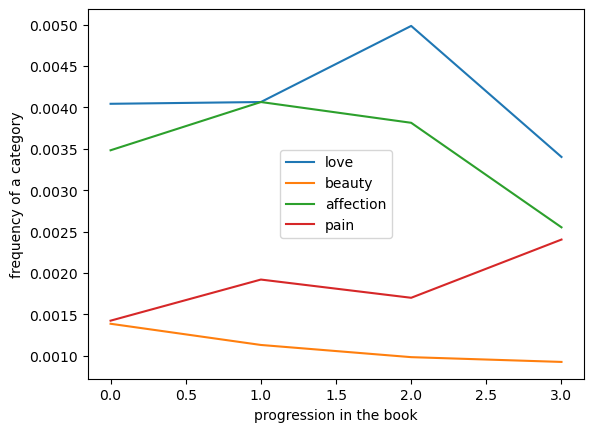

In [124]:
plt.plot(love,label = "love")
plt.plot(beauty, label = "beauty")
plt.plot(affection, label = "affection")
plt.plot(pain,label = "pain")

plt.xlabel("progression in the book")
plt.ylabel("frequency of a category")
plt.legend()

plt.show()

In [125]:
# We can observe how as the story progresses, beauty and affection categories decrease, while love and pain intensify!

### We can create custom categories based on seed terms!
### Models trained on: fiction, nytimes or reddit

**1. 创建 Empath 类别**
```python
lexicon.create_category("healthy_food", ["healthy_food", "low_carb", "kale", "avocado"], model="nytimes")
```

- **`lexicon.create_category`**：
  - 用于创建一个新的自定义类别。

- **参数**：
  - **类别名称 (`"healthy_food"`)**：
    - 新类别的名称，用于后续分析。
  - **词汇列表 (`["healthy_food", "low_carb", "kale", "avocado"]`)**：
    - 定义与该类别相关的关键词（即 "healthy_food" 类别包含的关键词）。
    - 当 Empath 分析文本时，如果出现这些关键词，便会将它们归入该类别。
  - **语料模型 (`model="nytimes"`)**：
    - 指定语料来源，以便 Empath 使用该语料来扩展类别的语义。
    - 例如，"nytimes" 模型表示 Empath 使用《纽约时报》数据作为基础扩展语义。
  
**2. 创建多个类别**
```python
lexicon.create_category("healthy_food", ["healthy_food", "low_carb", "kale", "avocado"], model="reddit")
```

- **作用**：
  - 再次创建名为 `"healthy_food"` 的类别，但这次使用 **"reddit"** 模型。
  - 因为不同语料（"nytimes" 和 "reddit"）可能会对关键词的上下文或相关性有不同理解。
  - 使用多个模型可以让类别在不同语境下的词语关联更加准确。

**3. 创建新的类别 `festive_food`**
```python
lexicon.create_category("festive_food", ["festive_food", "turkey", "eggnog"], model="nytimes")
```

- **类别名称 (`"festive_food"`)**：
  - 新类别的名称。
- **词汇列表 (`["festive_food", "turkey", "eggnog"]`)**：
  - 定义与 "festive_food" 类别相关的词语，如“火鸡（turkey）”和“蛋酒（eggnog）”。
- **语料模型 (`model="nytimes"`)**：
  - 通过使用《纽约时报》的语料数据来扩展这些词语的语义。

In [126]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:1080'
os.environ['https_proxy'] = 'https://127.0.0.1:1080'

In [129]:
lexicon.create_category("healthy_food", ["healthy_food","low_carb","kale","avocado"], model="nytimes")

ProxyError: HTTPConnectionPool(host='127.0.0.1', port=1080): Max retries exceeded with url: http://54.148.189.209:8000/create_category (Caused by ProxyError('Unable to connect to proxy', NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001EC138609D0>: Failed to establish a new connection: [WinError 10061] 由于目标计算机积极拒绝，无法连接。')))

In [102]:
lexicon.create_category("healthy_food", ["healthy_food","low_carb","kale","avocado"], model="reddit")

ConnectionError: HTTPConnectionPool(host='54.148.189.209', port=8000): Max retries exceeded with url: /create_category (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000173052E14D0>: Failed to establish a new connection: [WinError 10061] 由于目标计算机积极拒绝，无法连接。'))

In [130]:
lexicon.create_category("festive_food", ["festive_food","turkey","eggnog"], model="nytimes")

ProxyError: HTTPConnectionPool(host='127.0.0.1', port=1080): Max retries exceeded with url: http://54.148.189.209:8000/create_category (Caused by ProxyError('Unable to connect to proxy', NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001EC138439D0>: Failed to establish a new connection: [WinError 10061] 由于目标计算机积极拒绝，无法连接。')))

### List of further resources
    * NLTK
    * Jellyfish: string similarity library
    * TextBlob: simplified text processing
    * PyEnchant: language detection
    * WordNet: ontology of concepts (inc. in NLTK)
    * Stanford NLP (Java)
    * Tweet NLP: https://www.cs.cmu.edu/~ark/TweetNLP/

## Part 2

### Question 1:
An NLP preprocessing model, using the list of stopwords ['a', 'the', 'is', 'you', 'I','my','with','was'] for the input sentence
“I was driving down the street with my CAR! :)” <br>
gives the following output: {driving, down, street, car, :)}.
The model consists of: <br>

a) Stopword Removal, Casefolding and Stemming <br>
b) Stopword Removal and Casefolding <br>
c) Stopword Removal and Stemming <br>
d) Casefolding and Stemming <br>

In [132]:
# write your code and/or answer here
# 选b)

输入句子：
“I was driving down the street with my CAR! :)”

输出：
{driving, down, street, car, :)}

1. **Stopword Removal（去停用词）**：
   - 根据提供的停用词列表 `['a', 'the', 'is', 'you', 'I','my','with','was']`，从句子中移除这些词：
     - 原句：**“I was driving down the street with my CAR! :)”**
     - 移除后：**“driving down street CAR! :)”**

2. **Casefolding（大小写统一）**：
   - 将文本转为小写：
     - **“driving down street CAR! :)”** -> **“driving down street car! :)”**

3. **Stemming（词干提取）**：
   - 对单词提取词干，例如：
     - `driving` -> `drive`。
   - 如果使用了 Stemming，`driving` 会变成 `drive`，而输出中的 `driving` 没有被改变，因此 **Stemming** 没有被应用。

### Question 2:
What statement is false about topic detection using LSA: <br>

a) It finds the representation of documents and words in the latent "topic space" <br>
b) It produces topics interpretable in “word space” <br>
c) A document's topic representation is a probability distribution over topics <br>
d) The vectors representing topics in “word space” are linearly independent <br>

In [135]:
# write your code and/or answer here
# 选c)

**LSA 的主要原理**
1. **核心思想**：
   - LSA 使用 **SVD**（奇异值分解，Singular Value Decomposition）来分解 **文档-词项矩阵**。
   - 通过将词和文档投影到一个低维的 "潜在语义空间"（latent semantic space），捕捉文档和词之间的隐含语义关系。
   
2. **输出结果**：
   - 每个文档和词语都可以被表示为在 "潜在语义空间" 中的向量。
   - 潜在空间的维度可以理解为主题的数量，但这些主题本质上不是概率分布，而是线性组合的向量。

**a) It finds the representation of documents and words in the latent "topic space"**
- **正确**：
  - LSA 通过 SVD 将文档和词项表示为低维的 "潜在语义空间" 中的向量。
  - 这些向量是文档和词项在潜在语义主题上的表示。

**b) It produces topics interpretable in “word space”**
- **正确**：
  - 在 "词空间" 中，主题向量可以通过查看高权重词汇解释。
  - 这些向量由单词的线性组合表示，因此可以在“词空间”中理解主题。

**c) A document's topic representation is a probability distribution over topics**
- **错误**：
  - 在 LSA 中，文档的主题表示是一个向量（非负非概率），表示文档在潜在语义空间中的位置。
  - LSA 的输出不提供概率分布。
  - 概率分布的主题模型通常由 **LDA**（Latent Dirichlet Allocation）等方法提供，而不是 LSA。

**d) The vectors representing topics in “word space” are linearly independent**
- **正确**：
  - 在 LSA 中，使用 SVD 分解后得到的主题向量（即 SVD 的奇异向量）是线性独立的。这是 SVD 分解的一个基本特性。

### Question 3:
The problem of having more features than documents when using a TF-IDF matrix for document classification cannot be addressed by: <br>

a) Using SVD for dimensionality reduction <br>
b) Using min-max scaling of features <br>
c) Penalizing very large positive and very large negative weights (a.k.a. regularization) <br>
d) Using online feature selection <br>

In [136]:
# write your code and/or answer here
# 选b)

这道题考察如何解决 **文档特征比文档数量更多** 的问题，即 **高维问题**（High Dimensionality Problem）。我们需要从选项中找出一种 **无法解决** 该问题的方法。

**a) Using SVD for dimensionality reduction**
- **正确：可以解决高维问题**
  - **SVD（奇异值分解）** 是一种有效的降维方法。
  - 通过将特征投影到低维 "潜在语义空间"，可以减少特征数量，同时保留文档间的重要语义关系。
  - 适用于处理特征数量多于文档数量的情况。

**b) Using min-max scaling of features**
- **错误：无法解决高维问题**
  - **Min-max scaling** 是一种数据归一化技术，将特征值缩放到指定的范围（例如 [0,1]）。
  - 归一化可以让不同特征的数值范围一致，但 **不会减少特征数量**。
  - 它无法从根本上解决 "特征数量多于文档数量" 的问题，因为特征数量没有减少。

**c) Penalizing very large positive and very large negative weights (a.k.a. regularization)**
- **正确：可以缓解高维问题**
  - **正则化**（如 L1 或 L2 正则化）可以通过限制模型参数的大小来减少过拟合。
  - 特别是 L1 正则化（Lasso），可以将一些不重要的特征权重缩减为零，从而实现特征选择。
  - 这种方法可以在特征数量多于文档数量的情况下有效。

**d) Using online feature selection**
- **正确：可以解决高维问题**
  - **在线特征选择** 是一种动态选择重要特征的方法，通常在数据流环境中使用。
  - 它通过逐步评估特征的重要性，只保留相关特征，从而减少特征数量。
  - 这种方法可以直接应对 "特征数量多于文档数量" 的问题。

### Question 4:
Which of the following is false about word vectors: <br>

a) Word2vec is used to achieve a lower dimensional representation than bag of words <br>
b) Semantically similar words typically have similar word2vec vectors <br>
c) Each dimension in the word2vec embedding has a clear interpretation <br>
d) Word2Vec can be used for the computation of sentence vectors <br>

In [137]:
# write your code and/or answer here
# 选c)

**a) Word2vec is used to achieve a lower dimensional representation than bag of words**
- **正确：这是 Word2Vec 的一个显著优势**
  - Bag of Words（BOW）方法将词表示为高维稀疏向量，维度等于词汇表大小（可能是几千甚至几百万维）。
  - Word2Vec 则将每个词映射为低维稠密向量（例如 100 或 300 维），显著降低了维度，同时保留了语义信息。

**b) Semantically similar words typically have similar word2vec vectors**
- **正确：这是 Word2Vec 的核心特点**
  - Word2Vec 基于分布式假设（Distributional Hypothesis）：**语义相似的词倾向于出现在相似的上下文中**。
  - 通过训练，语义相似的词（如 "king" 和 "queen" 或 "man" 和 "woman"）在词向量空间中通常距离较近或具有相似的方向。

**c) Each dimension in the word2vec embedding has a clear interpretation**
- **错误：维度没有明确的语义解释**
  - Word2Vec 的维度是 **通过神经网络训练的稠密向量**，每个维度本质上是统计特征的混合，没有固定的语义意义。
  - 与 BOW 中 "某个维度表示某个单词" 不同，Word2Vec 的每一维都是模型自动学习的，不对应任何特定的解释。
  - 例如，Word2Vec 的一个维度不能明确表示 "性别" 或 "国籍"，而是这些语义的组合。

**d) Word2Vec can be used for the computation of sentence vectors**
- **正确：Word2Vec 可以用于句子向量的计算**
  - 尽管 Word2Vec 是针对单词训练的，但可以通过多种方法（如向量平均、权重加权等）将单词向量组合成句子向量。
  - 这种方法简单且有效，常用于许多 NLP 任务中。

### Question 5:
Given the following word (W) / context (C) co-occurrence frequencies, which statement is true regarding the pointwise mutual information (PMI)?

|  |W1|W2|W3|
|--|--|--|--|
|C1| 2| 0| 3|
|C2| 6| 4| 0|
|C3| 1| 1| 3|

a) PMI(w=W1, c=C2) > PMI(w=W2, c=C2) > PMI(w=W3, c=C3) <br>
b) PMI(w=W2, c=C2) > PMI(w=W1, c=C2) >  PMI(w=W3, c=C3) <br>
c) PMI(w=W3, c=C3) > PMI(w=W1, c=C2) > PMI(w=W2, c=C2) <br>
d) PMI(w=W3, c=C3) > PMI(w=W2, c=C2) > PMI(w=W1, c=C2) <br>

In [138]:
# write your code and/or answer here
# 选d)

PMI 是一种度量两个事件 \( w \) 和 \( c \) 之间关联程度的方法，公式如下：

\[
PMI(w, c) = \log \frac{P(w, c)}{P(w) P(c)}
\]

**计算 PMI 的步骤**

1. **定义符号和总频率**：
   - \( P(w, c) \) 是 \( w \) 和 \( c \) 的联合概率：该词 \( w \) 和上下文 \( c \) 同时出现的概率。
   - \( P(w) \) 是词 \( w \) 的边缘概率：该词 \( w \) 的所有上下文出现频率的总和除以总频率。
   - \( P(c) \) 是上下文 \( c \) 的边缘概率：该上下文 \( c \) 中所有词的出现频率的总和除以总频率。
   - 总频率为表中所有数字的总和：
     \[
     \text{总频率} = 2 + 0 + 3 + 6 + 4 + 0 + 1 + 1 + 3 = 20
     \]

2. **计算每个词 \( w \) 和上下文 \( c \) 的联合概率**：
   \[
   P(w, c) = \frac{\text{对应的频率值}}{\text{总频率}}
   \]

3. **计算边缘概率 \( P(w) \) 和 \( P(c) \)**：
   \[
   P(w) = \frac{\text{某词 \( w \) 的频率总和}}{\text{总频率}}
   \]
   \[
   P(c) = \frac{\text{某上下文 \( c \) 的频率总和}}{\text{总频率}}
   \]

4. **代入公式计算 PMI**：
   \[
   PMI(w, c) = \log \frac{P(w, c)}{P(w) \cdot P(c)}
   \]

**逐项计算 PMI**

**1. 计算频率总和**
- **词频率总和 \( P(w) \)：**
  - \( P(W1) = \frac{2 + 6 + 1}{20} = \frac{9}{20} \)
  - \( P(W2) = \frac{0 + 4 + 1}{20} = \frac{5}{20} \)
  - \( P(W3) = \frac{3 + 0 + 3}{20} = \frac{6}{20} \)

- **上下文频率总和 \( P(c) \)：**
  - \( P(C1) = \frac{2 + 0 + 3}{20} = \frac{5}{20} \)
  - \( P(C2) = \frac{6 + 4 + 0}{20} = \frac{10}{20} \)
  - \( P(C3) = \frac{1 + 1 + 3}{20} = \frac{5}{20} \)

**2. 计算 \( P(w, c) \)**
- \( P(W1, C2) = \frac{6}{20} \)
- \( P(W2, C2) = \frac{4}{20} \)
- \( P(W3, C3) = \frac{3}{20} \)

**3. 计算 PMI**
根据公式：
\[
PMI(w, c) = \log \frac{P(w, c)}{P(w) \cdot P(c)}
\]

- **PMI(W1, C2)**：
  \[
  PMI(W1, C2) = \log \frac{\frac{6}{20}}{\frac{9}{20} \cdot \frac{10}{20}} = \log \frac{6}{9 \cdot 10} = \log \frac{6}{90} = \log \frac{1}{15}
  \]

- **PMI(W2, C2)**：
  \[
  PMI(W2, C2) = \log \frac{\frac{4}{20}}{\frac{5}{20} \cdot \frac{10}{20}} = \log \frac{4}{5 \cdot 10} = \log \frac{4}{50} = \log \frac{2}{25}
  \]

- **PMI(W3, C3)**：
  \[
  PMI(W3, C3) = \log \frac{\frac{3}{20}}{\frac{6}{20} \cdot \frac{5}{20}} = \log \frac{3}{6 \cdot 5} = \log \frac{3}{30} = \log \frac{1}{10}
  \]

**比较 PMI**
根据上面的计算结果：

1. \( PMI(W3, C3) = \log \frac{1}{10} \)
2. \( PMI(W1, C2) = \log \frac{1}{15} \)
3. \( PMI(W2, C2) = \log \frac{2}{25} \)

比较大小：
\[
PMI(W3, C3) > PMI(W1, C2) > PMI(W2, C2)
\]
